### LAB 2.04: Different Ways to Chunk Podcast and PDF
Dina Bosma-Buczynska


**Step 1: Setup and Data Loading**


In [65]:
!pip install langchain langchain-text-splitters langchain-community pypdf2 python-dotenv openai tiktoken

In [66]:
# Import Required Libraries
# These are the tools we'll use throughout this lab

import os
from dotenv import load_dotenv
from langchain_text_splitters import (
    CharacterTextSplitter,
    RecursiveCharacterTextSplitter,
    TokenTextSplitter
)
import tiktoken
import pandas as pd
import matplotlib.pyplot as plt

# Load environment variables from .env file
load_dotenv()

print("All libraries imported successfully!")

All libraries imported successfully!


In [67]:
pip install openai pydub


Note: you may need to restart the kernel to use updated packages.


#### Upload and transcribe audio

In [68]:
import os

print("\n" + "="*60)
print(" CHECKING AUDIO FOLDER")
print("="*60)

audio_folder = "audio"
if os.path.exists(audio_folder):
    all_files = os.listdir(audio_folder)

    audio_extensions = ['.mp3', '.wav', '.m4a', '.ogg', '.flac']
    audio_files = [f for f in all_files 
                   if any(f.lower().endswith(ext) for ext in audio_extensions)]

    if audio_files:
        print(f"\nFound {len(audio_files)} audio file(s):\n")
        for i, filename in enumerate(audio_files, 1):
            filepath = os.path.join(audio_folder, filename)
            size_mb = os.path.getsize(filepath) / (1024 * 1024)
            print(f"   {i}. {filename}")
            print(f"      Size: {size_mb:.2f} MB")
            print(f"      Path: {filepath}\n")

        selected_audio = audio_files[0]
        audio_path = os.path.join(audio_folder, selected_audio)

        print(f"Will use: {selected_audio}")
        print(f"File size: {os.path.getsize(audio_path) / (1024*1024):.2f} MB")

    else:
        print("No audio files found!")
        print(f"   Please add an audio file (.mp3, .wav, .m4a) to '{audio_folder}/' folder")
else:
    print(f"Folder '{audio_folder}/' doesn't exist!")
    print("   Creating it now...")
    os.makedirs(audio_folder)
    print(f"   Created '{audio_folder}/' folder")
    print("   Please add your audio file to this folder")


 CHECKING AUDIO FOLDER

Found 1 audio file(s):

   1. The_Blueprint_For_Trustworthy_AI.m4a
      Size: 28.78 MB
      Path: audio/The_Blueprint_For_Trustworthy_AI.m4a

Will use: The_Blueprint_For_Trustworthy_AI.m4a
File size: 28.78 MB


In [69]:
from openai import OpenAI

client = OpenAI()
print("OpenAI client initialized!")

OpenAI client initialized!


In [71]:
import subprocess
import static_ffmpeg
static_ffmpeg.add_paths()

print("="*60)
print("SPLITTING AUDIO + TRANSCRIBING PODCAST")
print("="*60)

# Split into 2 halves using ffmpeg stream copy (no re-encoding = fast)
os.makedirs("audio/chunks", exist_ok=True)

# Get duration using ffprobe
result = subprocess.run(
    ["ffprobe", "-v", "quiet", "-show_entries", "format=duration",
     "-of", "default=noprint_wrappers=1:nokey=1", audio_path],
    capture_output=True, text=True
)
total_duration = float(result.stdout.strip())
half = total_duration / 2
print(f"Audio duration: {total_duration:.1f}s ({total_duration/60:.1f} min)")

chunk_paths = []
for i, (start, dur) in enumerate([(0, half), (half, half + 10)]):
    chunk_path = f"audio/chunks/chunk_{i}.m4a"
    subprocess.run(
        ["ffmpeg", "-y", "-i", audio_path, "-ss", str(start), "-t", str(dur),
         "-c", "copy", chunk_path],
        capture_output=True
    )
    size_mb = os.path.getsize(chunk_path) / (1024 * 1024)
    print(f"  Chunk {i+1}: {size_mb:.2f} MB -> {chunk_path}")
    chunk_paths.append(chunk_path)

# Transcribe each chunk
selected_prompt = "This is a podcast about trustworthy AI, artificial intelligence ethics, EU regulations, and responsible AI development."

print(f"\nTranscribing {len(chunk_paths)} chunks...")
all_texts = []
for i, chunk_path in enumerate(chunk_paths):
    print(f"  Chunk {i+1}/{len(chunk_paths)}...", end=" ")
    with open(chunk_path, "rb") as f:
        transcript = client.audio.transcriptions.create(
            model="whisper-1",
            file=f,
            prompt=selected_prompt
        )
    all_texts.append(transcript.text)
    print("done")

podcast_text = " ".join(all_texts)
print(f"\nTranscription complete! {len(podcast_text)} characters")
print(f"\nPreview:\n{podcast_text[:500]}...")

SPLITTING AUDIO + TRANSCRIBING PODCAST
Audio duration: 937.5s (15.6 min)
  Chunk 1: 14.38 MB -> audio/chunks/chunk_0.m4a
  Chunk 2: 14.38 MB -> audio/chunks/chunk_1.m4a

Transcribing 2 chunks...
  Chunk 1/2... done
  Chunk 2/2... done

Transcription complete! 16680 characters

Preview:
So imagine for a second you're driving across, I don't know, a massive suspension bridge. Okay. You don't pull over halfway across, get out and demand to see the blueprints, right? You don't interview the welding crew. No, you just, you trust it. You just drive. You trust the bridge. You trust the engineering standards, the inspections, the laws that say this thing won't fail. Right. It's trust in the infrastructure. It's invisible, but it's there. Exactly. But now let's switch gears. Think abou...


In [ ]:
# Save full transcription to file
os.makedirs("transcriptions", exist_ok=True)
output_file = "transcriptions/chunked_transcription.txt"
with open(output_file, "w", encoding="utf-8") as f:
    f.write(podcast_text)

print(f"Saved transcription ({len(podcast_text)} characters) to: {output_file}")

Saved transcription (16679 characters) to: transcriptions/chunked_transcription.txt


#### Import pdf

In [ ]:

from pathlib import Path

pdf_file = Path("trustworthy_ai.pdf")

try:
    from pypdf import PdfReader
except ModuleNotFoundError as exc:
    print("Module 'pypdf' is not installed. Run `pip install pypdf` and retry.")
    raise

if not pdf_file.exists():
    print(f"ERROR: Could not find {pdf_file.name}")
    print("\nINSTRUCTIONS:")
    print("1. Place your PDF in the same folder as this notebook")
    print(f"2. Make sure the filename above matches the file you want to load ({pdf_file.name})")
    print("3. Run this cell again")
    pdf_text = None
else:
    reader = PdfReader(pdf_file)
    pages = []
    for page in reader.pages:
        text = page.extract_text()
        if text:
            pages.append(text)
    pdf_text = "\n".join(pages)

    print("PDF DOCUMENT LOADED")
    print(f"  File: {pdf_file.name}")
    print(f"  Length: {len(pdf_text)} characters")
    print(f"  Preview: {pdf_text[:150]}...")


PDF DOCUMENT LOADED
  File: trustworthy_ai.pdf
  Length: 194198 characters
  Preview:  
 
GROUPE D’EXPERTS 
INDEPENDANTS DE HAUT NIVEAU SUR 
L’INTELLIGENCE ARTIFICIELLE 
CONSTITUE PAR LA COMMISSION EUROPEENNE EN JUIN 2018 
 
 
 
 
 
 
 ...


**Step 2: Implement Fixed-Size Chunking**

In [ ]:
from pinecone import Pinecone, ServerlessSpec

# Initialize Pinecone client
pc = Pinecone(api_key=os.environ["PINECONE_API_KEY"])

# Create or connect to an index
index_name = "rag-openai-index"

# Check if index exists, create if not
existing_indexes = [index.name for index in pc.list_indexes()]
if index_name not in existing_indexes:
    pc.create_index(
        name=index_name,
        dimension=1536,  # OpenAI text-embedding-3-small dimension
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1")
    )
    print(f"Created index: {index_name}")
else:
    print(f"Index {index_name} already exists")

Index rag-openai-index already exists


In [ ]:
fixed_splitter = CharacterTextSplitter(
    chunk_size=500,        # Each chunk = 500 characters
    chunk_overlap=50,      # Last 50 chars of chunk 1 repeat at start of chunk 2
    separator=" "          # Split on spaces (don't break words)
)

print("Fixed-Size Chunker created!")
print(f"  chunk_size = 500 characters")
print(f"  chunk_overlap = 50 characters")
print(f"  separator = space character (avoid breaking words)")

Fixed-Size Chunker created!
  chunk_size = 500 characters
  chunk_overlap = 50 characters
  separator = space character (avoid breaking words)


In [ ]:
# Custom chunking function (replaces RecursiveCharacterTextSplitter)
def chunk_text(text, chunk_size=500, chunk_overlap=50):
    """
    Split text into chunks with overlap.
    
    Args:
        text: The text to chunk
        chunk_size: Maximum size of each chunk
        chunk_overlap: Number of characters to overlap between chunks
    
    Returns:
        List of chunk dictionaries with 'page_content' and 'metadata'
    """
    chunks = []
    start = 0
    
    while start < len(text):
        end = start + chunk_size
        chunk = text[start:end]
        
        chunks.append({
            "page_content": chunk,
            "metadata": {"start": start, "end": end}
        })
        
        # Move start position forward, accounting for overlap
        start += chunk_size - chunk_overlap
        
        # Prevent infinite loop if chunk_size <= chunk_overlap
        if chunk_size <= chunk_overlap:
            break
    
    return chunks

def chunk_documents(documents, chunk_size=500, chunk_overlap=50):
    """
    Chunk a list of documents.
    
    Args:
        documents: List of document dictionaries with 'page_content'
        chunk_size: Maximum size of each chunk
        chunk_overlap: Number of characters to overlap between chunks
    
    Returns:
        List of chunk dictionaries
    """
    all_chunks = []
    for i, doc in enumerate(documents):
        text = doc["page_content"]
        chunks = chunk_text(text, chunk_size, chunk_overlap)
        # Add document index to metadata
        for chunk in chunks:
            chunk["metadata"]["document_index"] = i
        all_chunks.extend(chunks)
    return all_chunks

# Build the documents list from the loaded sources
documents = [
    {"page_content": pdf_text},
    {"page_content": podcast_text}
]

# Chunk the documents
chunks = chunk_documents(documents, chunk_size=500, chunk_overlap=50)
print(f"Number of chunks: {len(chunks)}")
print(f"First chunk: {chunks[0]['page_content'][:100]}...")

Number of chunks: 470
First chunk:  
 
GROUPE D’EXPERTS 
INDEPENDANTS DE HAUT NIVEAU SUR 
L’INTELLIGENCE ARTIFICIELLE 
CONSTITUE PAR LA...


**Experiment: Fixed-Size Chunking with Different Parameters**

In [ ]:
# Experiment 1: Different chunk sizes (500, 1000, 2000) with fixed overlap of 50
chunk_sizes = [500, 1000, 2000]
overlap = 50

results = []

for size in chunk_sizes:
    splitter = CharacterTextSplitter(chunk_size=size, chunk_overlap=overlap, separator=" ")

    pdf_chunks = splitter.split_text(pdf_text)
    podcast_chunks = splitter.split_text(podcast_text)

    pdf_lengths = [len(c) for c in pdf_chunks]
    podcast_lengths = [len(c) for c in podcast_chunks]

    results.append({
        "chunk_size": size,
        "overlap": overlap,
        "pdf_num_chunks": len(pdf_chunks),
        "pdf_avg_len": sum(pdf_lengths) / len(pdf_lengths),
        "pdf_min_len": min(pdf_lengths),
        "pdf_max_len": max(pdf_lengths),
        "podcast_num_chunks": len(podcast_chunks),
        "podcast_avg_len": sum(podcast_lengths) / len(podcast_lengths),
        "podcast_min_len": min(podcast_lengths),
        "podcast_max_len": max(podcast_lengths),
    })

df_sizes = pd.DataFrame(results)

print("="*70)
print(" EXPERIMENT 1: Varying Chunk Size (overlap = 50)")
print("="*70)
print(f"\n{'Size':>6} | {'PDF Chunks':>10} {'Avg Len':>8} {'Min':>5} {'Max':>5} | {'Podcast Chunks':>14} {'Avg Len':>8} {'Min':>5} {'Max':>5}")
print("-"*70)
for _, r in df_sizes.iterrows():
    print(f"{int(r['chunk_size']):>6} | {int(r['pdf_num_chunks']):>10} {r['pdf_avg_len']:>8.0f} {int(r['pdf_min_len']):>5} {int(r['pdf_max_len']):>5} | {int(r['podcast_num_chunks']):>14} {r['podcast_avg_len']:>8.0f} {int(r['podcast_min_len']):>5} {int(r['podcast_max_len']):>5}")

# Show sample chunks at each size
for size in chunk_sizes:
    splitter = CharacterTextSplitter(chunk_size=size, chunk_overlap=overlap, separator=" ")
    pdf_sample = splitter.split_text(pdf_text)[0]
    podcast_sample = splitter.split_text(podcast_text)[0]

    print(f"\n{'='*70}")
    print(f" CHUNK SIZE = {size} characters")
    print(f"{'='*70}")
    print(f"\n  PDF chunk 1 ({len(pdf_sample)} chars):")
    print(f"  {repr(pdf_sample[:150])}...")
    print(f"\n  Podcast chunk 1 ({len(podcast_sample)} chars):")
    print(f"  {repr(podcast_sample[:150])}...")

 EXPERIMENT 1: Varying Chunk Size (overlap = 50)

  Size | PDF Chunks  Avg Len   Min   Max | Podcast Chunks  Avg Len   Min   Max
----------------------------------------------------------------------
   500 |        427      495   120   500 |             37      497   486   500
  1000 |        202      995   884  1000 |             18      972   553  1000
  2000 |         99     1983   649  2000 |              9     1896  1078  2000

 CHUNK SIZE = 500 characters

  PDF chunk 1 (495 chars):
  'GROUPE D’EXPERTS \nINDEPENDANTS DE HAUT NIVEAU SUR \nL’INTELLIGENCE ARTIFICIELLE \nCONSTITUE PAR LA COMMISSION EUROPEENNE EN JUIN 2018 \n \n \n \n \n \n \n \nLIG'...

  Podcast chunk 1 (495 chars):
  "So imagine for a second you're driving across, I don't know, a massive suspension bridge. Okay. You don't pull over halfway across, get out and demand"...

 CHUNK SIZE = 1000 characters

  PDF chunk 1 (994 chars):
  'GROUPE D’EXPERTS \nINDEPENDANTS DE HAUT NIVEAU SUR \nL’INTELLIGENCE ARTIFICIELLE \nC

In [ ]:
# Different overlap values (0, 50, 100) with fixed chunk size of 500
chunk_size = 500
overlaps = [0, 50, 100]

results_overlap = []

for ov in overlaps:
    splitter = CharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=ov, separator=" ")

    pdf_chunks = splitter.split_text(pdf_text)
    podcast_chunks = splitter.split_text(podcast_text)

    pdf_lengths = [len(c) for c in pdf_chunks]
    podcast_lengths = [len(c) for c in podcast_chunks]

    results_overlap.append({
        "overlap": ov,
        "chunk_size": chunk_size,
        "pdf_num_chunks": len(pdf_chunks),
        "pdf_avg_len": sum(pdf_lengths) / len(pdf_lengths),
        "podcast_num_chunks": len(podcast_chunks),
        "podcast_avg_len": sum(podcast_lengths) / len(podcast_lengths),
    })

df_overlaps = pd.DataFrame(results_overlap)

print("="*70)
print(" EXPERIMENT 2: Varying Overlap (chunk_size = 500)")
print("="*70)
print(f"\n{'Overlap':>7} | {'PDF Chunks':>10} {'Avg Len':>8} | {'Podcast Chunks':>14} {'Avg Len':>8}")
print("-"*60)
for _, r in df_overlaps.iterrows():
    print(f"{int(r['overlap']):>7} | {int(r['pdf_num_chunks']):>10} {r['pdf_avg_len']:>8.0f} | {int(r['podcast_num_chunks']):>14} {r['podcast_avg_len']:>8.0f}")

# Show how overlap affects chunk boundaries
print(f"\n{'='*70}")
print(" OVERLAP EFFECT: Where chunk 1 ends vs chunk 2 starts")
print(f"{'='*70}")

for ov in overlaps:
    splitter = CharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=ov, separator=" ")
    podcast_chunks = splitter.split_text(podcast_text)

    c1_end = podcast_chunks[0][-60:]
    c2_start = podcast_chunks[1][:60:]

    print(f"\n  Overlap = {ov}:")
    print(f"    Chunk 1 ends with:    ...{repr(c1_end)}")
    print(f"    Chunk 2 starts with:  {repr(c2_start)}...")
    if ov > 0:
        # Find actual repeated text
        shared = ""
        for i in range(1, min(len(podcast_chunks[0]), len(podcast_chunks[1])) + 1):
            if podcast_chunks[0].endswith(podcast_chunks[1][:i]):
                shared = podcast_chunks[1][:i]
        print(f"    Shared text ({len(shared)} chars): {repr(shared[:80])}{'...' if len(shared) > 80 else ''}")

 EXPERIMENT 2: Varying Overlap (chunk_size = 500)

Overlap | PDF Chunks  Avg Len | Podcast Chunks  Avg Len
------------------------------------------------------------
      0 |        386      496 |             34      490
     50 |        427      495 |             37      497
    100 |        481      495 |             42      492

 OVERLAP EFFECT: Where chunk 1 ends vs chunk 2 starts

  Overlap = 0:
    Chunk 1 ends with:    ...", but it's there. Exactly. But now let's switch gears. Think"
    Chunk 2 starts with:  'about the algorithm that just denied your mortgage applicati'...

  Overlap = 50:
    Chunk 1 ends with:    ...", but it's there. Exactly. But now let's switch gears. Think"
    Chunk 2 starts with:  "there. Exactly. But now let's switch gears. Think about the "...
    Shared text (49 chars): "there. Exactly. But now let's switch gears. Think"

  Overlap = 100:
    Chunk 1 ends with:    ...", but it's there. Exactly. But now let's switch gears. Think"
    Chunk 2 starts

In [ ]:
# PDF vs Podcast comparison — does fixed-size chunking break sentences?
chunk_sizes = [500, 1000, 2000]

print("="*70)
print("PDF vs Podcast — Sentence Boundary Analysis")
print("="*70)

for size in chunk_sizes:
    splitter = CharacterTextSplitter(chunk_size=size, chunk_overlap=50, separator=" ")

    pdf_chunks = splitter.split_text(pdf_text)
    podcast_chunks = splitter.split_text(podcast_text)

    # Count chunks that end mid-sentence (don't end with . ! ? or \n)
    pdf_broken = sum(1 for c in pdf_chunks if not c.rstrip().endswith(('.', '!', '?', '\n')))
    podcast_broken = sum(1 for c in podcast_chunks if not c.rstrip().endswith(('.', '!', '?', '\n')))

    pdf_pct = pdf_broken / len(pdf_chunks) * 100
    podcast_pct = podcast_broken / len(podcast_chunks) * 100

    print(f"\n  Chunk size = {size}:")
    print(f"    PDF:     {pdf_broken}/{len(pdf_chunks)} chunks break mid-sentence ({pdf_pct:.0f}%)")
    print(f"    Podcast: {podcast_broken}/{len(podcast_chunks)} chunks break mid-sentence ({podcast_pct:.0f}%)")

# Side-by-side chunk boundary examples
print(f"\n{'='*70}")
print(" SIDE-BY-SIDE: How chunks end (size=500, overlap=50)")
print(f"{'='*70}")

splitter = CharacterTextSplitter(chunk_size=500, chunk_overlap=50, separator=" ")
pdf_chunks = splitter.split_text(pdf_text)
podcast_chunks = splitter.split_text(podcast_text)

for i in range(min(5, len(pdf_chunks), len(podcast_chunks))):
    print(f"\n  Chunk {i+1}:")
    print(f"    PDF ends with:     ...{repr(pdf_chunks[i][-80:])}")
    print(f"    Podcast ends with: ...{repr(podcast_chunks[i][-80:])}")

print(f"\n{'='*40}")
print("OBSERVATIONS")
print(f"{'='*40}")
print("""
  - PDF (structured text): Has paragraph breaks, headers, and formatting.
    Fixed-size chunking often cuts through structured sections.

  - Podcast (conversational text): Continuous speech without clear paragraphs.
    Fixed-size chunking frequently breaks mid-sentence.

  - Larger chunk sizes reduce the % of broken sentences but may include
    mixed topics in a single chunk.

  - Overlap helps preserve context at boundaries but increases total chunks.
""")

PDF vs Podcast — Sentence Boundary Analysis

  Chunk size = 500:
    PDF:     423/427 chunks break mid-sentence (99%)
    Podcast: 30/37 chunks break mid-sentence (81%)

  Chunk size = 1000:
    PDF:     196/202 chunks break mid-sentence (97%)
    Podcast: 13/18 chunks break mid-sentence (72%)

  Chunk size = 2000:
    PDF:     95/99 chunks break mid-sentence (96%)
    Podcast: 8/9 chunks break mid-sentence (89%)

 SIDE-BY-SIDE: How chunks end (size=500, overlap=50)

  Chunk 1:
    PDF ends with:     ...'té rédigé par le groupe d’experts de haut niveau sur l’intelligence artificielle'
    Podcast ends with: ..."ture. It's invisible, but it's there. Exactly. But now let's switch gears. Think"

  Chunk 2:
    PDF ends with:     ...'our une IA digne de confiance présentée au chapitre III du présent document. Une'
    Podcast ends with: ..."'re unpacking a document that is arguably the Magna Carta for ethical computing,"

  Chunk 3:
    PDF ends with:     ...'ur l’IA \nAdresse électronique

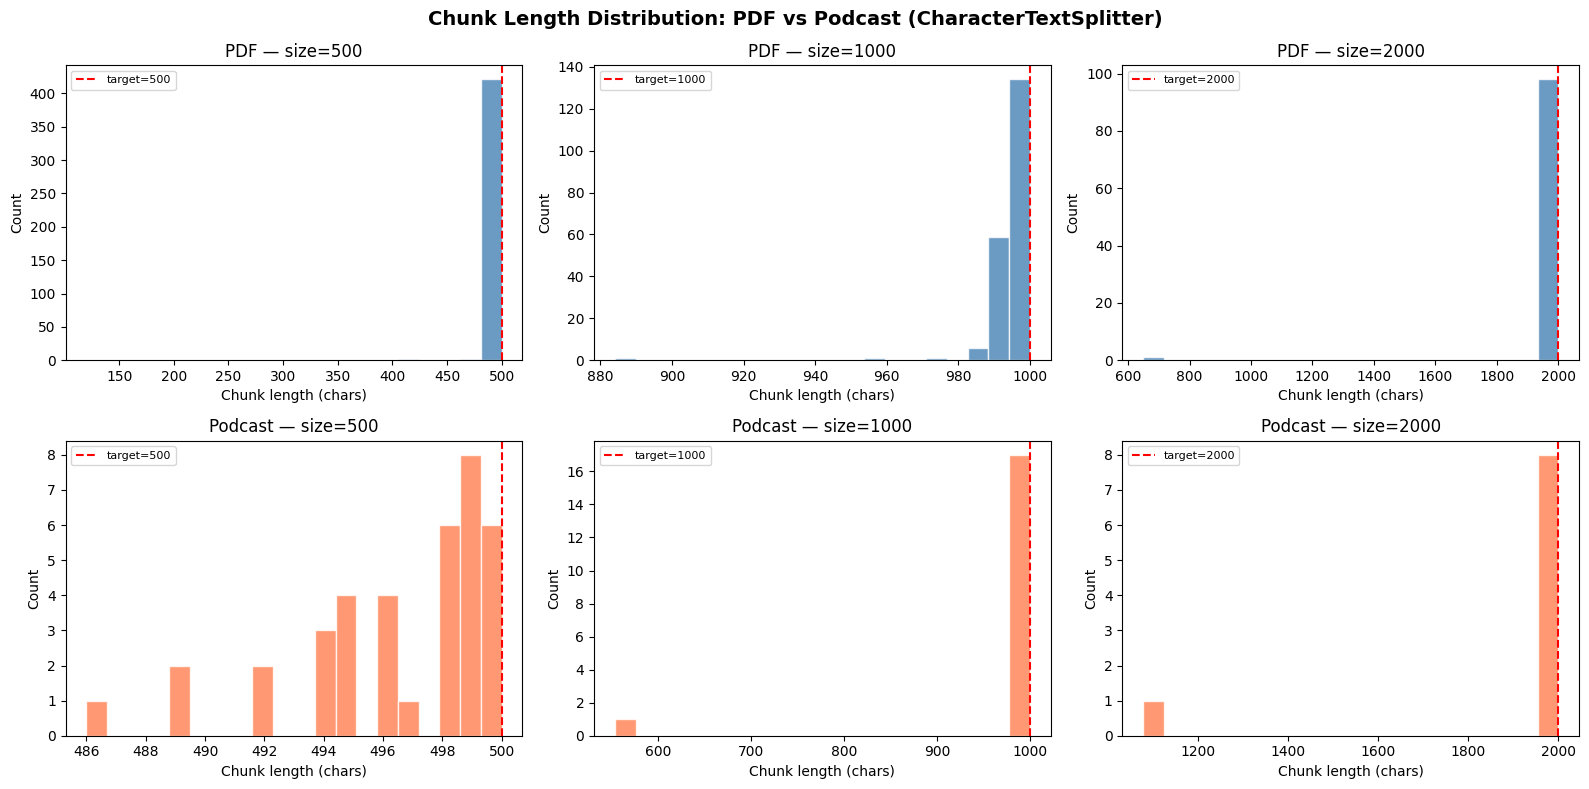

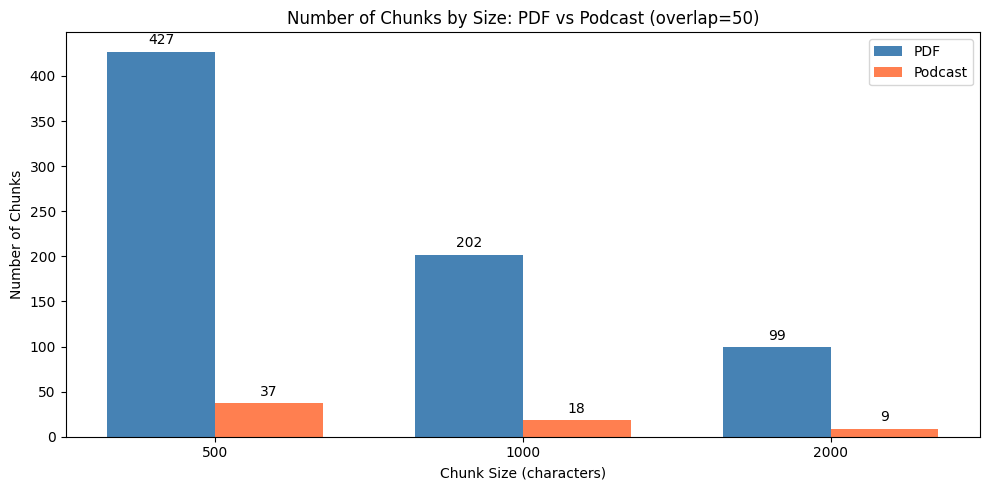

In [ ]:
# Visualize chunk length distributions
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
fig.suptitle("Chunk Length Distribution: PDF vs Podcast (CharacterTextSplitter)", fontsize=14, fontweight="bold")

chunk_sizes = [500, 1000, 2000]
overlap = 50

for col, size in enumerate(chunk_sizes):
    splitter = CharacterTextSplitter(chunk_size=size, chunk_overlap=overlap, separator=" ")

    pdf_chunks = splitter.split_text(pdf_text)
    podcast_chunks = splitter.split_text(podcast_text)

    pdf_lengths = [len(c) for c in pdf_chunks]
    podcast_lengths = [len(c) for c in podcast_chunks]

    # PDF histogram
    axes[0, col].hist(pdf_lengths, bins=20, color="steelblue", edgecolor="white", alpha=0.8)
    axes[0, col].set_title(f"PDF — size={size}")
    axes[0, col].set_xlabel("Chunk length (chars)")
    axes[0, col].set_ylabel("Count")
    axes[0, col].axvline(x=size, color="red", linestyle="--", label=f"target={size}")
    axes[0, col].legend(fontsize=8)

    # Podcast histogram
    axes[1, col].hist(podcast_lengths, bins=20, color="coral", edgecolor="white", alpha=0.8)
    axes[1, col].set_title(f"Podcast — size={size}")
    axes[1, col].set_xlabel("Chunk length (chars)")
    axes[1, col].set_ylabel("Count")
    axes[1, col].axvline(x=size, color="red", linestyle="--", label=f"target={size}")
    axes[1, col].legend(fontsize=8)

plt.tight_layout()
plt.show()

# Summary bar chart: number of chunks per configuration
fig, ax = plt.subplots(figsize=(10, 5))
x = range(len(chunk_sizes))
width = 0.35

pdf_counts = []
podcast_counts = []
for size in chunk_sizes:
    splitter = CharacterTextSplitter(chunk_size=size, chunk_overlap=overlap, separator=" ")
    pdf_counts.append(len(splitter.split_text(pdf_text)))
    podcast_counts.append(len(splitter.split_text(podcast_text)))

bars1 = ax.bar([i - width/2 for i in x], pdf_counts, width, label="PDF", color="steelblue")
bars2 = ax.bar([i + width/2 for i in x], podcast_counts, width, label="Podcast", color="coral")

ax.set_xlabel("Chunk Size (characters)")
ax.set_ylabel("Number of Chunks")
ax.set_title("Number of Chunks by Size: PDF vs Podcast (overlap=50)")
ax.set_xticks(list(x))
ax.set_xticklabels([str(s) for s in chunk_sizes])
ax.legend()
ax.bar_label(bars1, padding=3)
ax.bar_label(bars2, padding=3)

plt.tight_layout()
plt.show()

**Step 3: Implement Recursive Character Chunking**


In [ ]:

recursive_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,                                    # Target size: 1000 characters
    chunk_overlap=200,                                  # Overlap: 200 characters
    length_function=len,                                # Measure size using character count
    separators=["\n\n", "\n", ". ", " ", ""]        # Priority order for splitting
)

print("Recursive Character Chunker created!")
print(f"  chunk_size = 1000 characters")
print(f"  chunk_overlap = 200 characters")
print(f"  separators (priority order):")
print(f"    1. Paragraph breaks (\\n\\n)")
print(f"    2. Line breaks (\\n)")
print(f"    3. Sentence ends (. )")
print(f"    4. Word spaces ( )")
print(f"    5. Characters (last resort)")

Recursive Character Chunker created!
  chunk_size = 1000 characters
  chunk_overlap = 200 characters
  separators (priority order):
    1. Paragraph breaks (\n\n)
    2. Line breaks (\n)
    3. Sentence ends (. )
    4. Word spaces ( )
    5. Characters (last resort)


**Recursive Character Chunking with Different Parameters**

In [ ]:
# Recursive chunking — vary chunk size (500, 1000, 2000), overlap=200
chunk_sizes = [500, 1000, 2000]
overlap = 200
default_separators = ["\n\n", "\n", ". ", " ", ""]

results_recursive = []

for size in chunk_sizes:
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=size, chunk_overlap=overlap,
        separators=default_separators, length_function=len
    )
    pdf_chunks = splitter.split_text(pdf_text)
    podcast_chunks = splitter.split_text(podcast_text)

    pdf_lengths = [len(c) for c in pdf_chunks]
    podcast_lengths = [len(c) for c in podcast_chunks]

    # Count mid-sentence breaks
    pdf_broken = sum(1 for c in pdf_chunks if not c.rstrip().endswith(('.', '!', '?', '\n')))
    podcast_broken = sum(1 for c in podcast_chunks if not c.rstrip().endswith(('.', '!', '?', '\n')))

    results_recursive.append({
        "chunk_size": size,
        "pdf_num_chunks": len(pdf_chunks),
        "pdf_avg_len": sum(pdf_lengths) / len(pdf_lengths),
        "pdf_min_len": min(pdf_lengths),
        "pdf_max_len": max(pdf_lengths),
        "pdf_broken_pct": pdf_broken / len(pdf_chunks) * 100,
        "podcast_num_chunks": len(podcast_chunks),
        "podcast_avg_len": sum(podcast_lengths) / len(podcast_lengths),
        "podcast_min_len": min(podcast_lengths),
        "podcast_max_len": max(podcast_lengths),
        "podcast_broken_pct": podcast_broken / len(podcast_chunks) * 100,
    })

df_recursive = pd.DataFrame(results_recursive)

print("="*80)
print(" Recursive Chunking — Varying Chunk Size (overlap=200)")
print("="*80)
print(f"\n{'Size':>6} | {'PDF':>4} {'AvgLen':>7} {'Min':>5} {'Max':>5} {'Broken':>7} | {'Podcast':>7} {'AvgLen':>7} {'Min':>5} {'Max':>5} {'Broken':>7}")
print("-"*80)
for _, r in df_recursive.iterrows():
    print(f"{int(r['chunk_size']):>6} | {int(r['pdf_num_chunks']):>4} {r['pdf_avg_len']:>7.0f} {int(r['pdf_min_len']):>5} {int(r['pdf_max_len']):>5} {r['pdf_broken_pct']:>6.0f}% | {int(r['podcast_num_chunks']):>7} {r['podcast_avg_len']:>7.0f} {int(r['podcast_min_len']):>5} {int(r['podcast_max_len']):>5} {r['podcast_broken_pct']:>6.0f}%")

# Show sample chunks to see how recursive splitting respects structure
print(f"\n{'='*80}")
print(" SAMPLE CHUNKS: How recursive splitting respects text boundaries")
print(f"{'='*80}")

for size in chunk_sizes:
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=size, chunk_overlap=overlap,
        separators=default_separators, length_function=len
    )
    pdf_chunks = splitter.split_text(pdf_text)
    podcast_chunks = splitter.split_text(podcast_text)

    print(f"\n--- Chunk size = {size} ---")
    print(f"  PDF chunk 1 ends with:     ...{repr(pdf_chunks[0][-100:])}")
    print(f"  PDF chunk 2 starts with:   {repr(pdf_chunks[1][:100])}...")
    print(f"  Podcast chunk 1 ends with: ...{repr(podcast_chunks[0][-100:])}")
    print(f"  Podcast chunk 2 starts with: {repr(podcast_chunks[1][:100])}...")

 Recursive Chunking — Varying Chunk Size (overlap=200)

  Size |  PDF  AvgLen   Min   Max  Broken | Podcast  AvgLen   Min   Max  Broken
--------------------------------------------------------------------------------
   500 |  627     438    89   498     83% |      54     466   363   500     98%
  1000 |  240     934    89   998     82% |      21     946   809   995     95%
  2000 |  110    1887    89  1996     76% |      10    1818   466  2000     90%

 SAMPLE CHUNKS: How recursive splitting respects text boundaries

--- Chunk size = 500 ---
  PDF chunk 1 ends with:     ...'présent document a été rédigé par le groupe d’experts de haut niveau sur l’intelligence artificielle'
  PDF chunk 2 starts with:   'Groupe d’experts de haut niveau sur l’intelligence artificielle \n \n \n \n \n \n \n \n \nLe présent document'...
  Podcast chunk 1 ends with: ..."t's trust in the infrastructure. It's invisible, but it's there. Exactly. But now let's switch gears"
  Podcast chunk 2 starts with: ". Rig

In [ ]:
# Different separator priorities (chunk_size=1000, overlap=200)
# Test how different separator hierarchies affect chunk quality

separator_configs = {
    "Default (paragraph > line > sentence > word)": ["\n\n", "\n", ". ", " ", ""],
    "Sentence-first (sentence > paragraph > line > word)": [". ", "\n\n", "\n", " ", ""],
    "Paragraph-only (paragraph > word)": ["\n\n", " ", ""],
    "Word-only (space only)": [" ", ""],
}

chunk_size = 1000
overlap = 200

print("="*80)
print("Different Separator Priorities (size=1000, overlap=200)")
print("="*80)

for name, seps in separator_configs.items():
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=overlap,
        separators=seps, length_function=len
    )

    pdf_chunks = splitter.split_text(pdf_text)
    podcast_chunks = splitter.split_text(podcast_text)

    pdf_broken = sum(1 for c in pdf_chunks if not c.rstrip().endswith(('.', '!', '?', '\n')))
    podcast_broken = sum(1 for c in podcast_chunks if not c.rstrip().endswith(('.', '!', '?', '\n')))

    pdf_lengths = [len(c) for c in pdf_chunks]
    podcast_lengths = [len(c) for c in podcast_chunks]

    print(f"\n  {name}")
    print(f"  Separators: {seps}")
    print(f"  {'':>4} {'Chunks':>7} {'AvgLen':>7} {'Min':>5} {'Max':>5} {'Mid-sentence breaks':>20}")
    print(f"  {'PDF':>4} {len(pdf_chunks):>7} {sum(pdf_lengths)/len(pdf_lengths):>7.0f} {min(pdf_lengths):>5} {max(pdf_lengths):>5} {pdf_broken}/{len(pdf_chunks):>4} ({pdf_broken/len(pdf_chunks)*100:.0f}%)")
    print(f"  {'Pod':>4} {len(podcast_chunks):>7} {sum(podcast_lengths)/len(podcast_lengths):>7.0f} {min(podcast_lengths):>5} {max(podcast_lengths):>5} {podcast_broken}/{len(podcast_chunks):>4} ({podcast_broken/len(podcast_chunks)*100:.0f}%)")

    # Show how chunk 3 looks under each config (chunk 3 is usually past headers)
    print(f"  PDF chunk 3 ends:     ...{repr(pdf_chunks[2][-70:])}")
    print(f"  Podcast chunk 3 ends: ...{repr(podcast_chunks[2][-70:])}")

print(f"\n{'='*80}")
print(" KEY TAKEAWAY")
print(f"{'='*80}")
print("""
  - 'Default' separators work well for PDFs: splits on paragraph/line breaks
    first, preserving document structure (headers, sections).

  - 'Sentence-first' helps conversational text (podcast): prioritizes
    splitting at sentence boundaries over line breaks.

  - 'Word-only' behaves like CharacterTextSplitter — no structural awareness,
    just splits on spaces. Highest mid-sentence break rate.

  - For PDFs: Default or Paragraph-only separators respect document layout.
  - For Podcasts: Sentence-first separators produce cleaner chunks.
""")

Different Separator Priorities (size=1000, overlap=200)

  Default (paragraph > line > sentence > word)
  Separators: ['\n\n', '\n', '. ', ' ', '']
        Chunks  AvgLen   Min   Max  Mid-sentence breaks
   PDF     240     934    89   998 196/ 240 (82%)
   Pod      21     946   809   995 20/  21 (95%)
  PDF chunk 3 ends:     ...' haut niveau sur l’intelligence artificielle sont disponibles en ligne'
  Podcast chunk 3 ends: ...'tem. Not just at launch. Not just at launch. From design to retirement'

  Sentence-first (sentence > paragraph > line > word)
  Separators: ['. ', '\n\n', '\n', ' ', '']
        Chunks  AvgLen   Min   Max  Mid-sentence breaks
   PDF     248     862   184   999 236/ 248 (95%)
   Pod      21     946   809   995 20/  21 (95%)
  PDF chunk 3 ends:     ...'ital-single-market/en/high-level-expert-group-artificial-intelligence)'
  Podcast chunk 3 ends: ...'tem. Not just at launch. Not just at launch. From design to retirement'

  Paragraph-only (paragraph > word)
  Sepa

In [ ]:
# Recursive vs Fixed-Size at each chunk size
chunk_sizes = [500, 1000, 2000]
overlap = 50  # same overlap for fair comparison

print("="*80)
print("Recursive vs Fixed-Size — Side-by-Side Comparison")
print("="*80)

comparison_rows = []

for size in chunk_sizes:
    # Fixed-size (CharacterTextSplitter)
    fixed = CharacterTextSplitter(chunk_size=size, chunk_overlap=overlap, separator=" ")
    pdf_fixed = fixed.split_text(pdf_text)
    pod_fixed = fixed.split_text(podcast_text)

    # Recursive (RecursiveCharacterTextSplitter)
    recursive = RecursiveCharacterTextSplitter(
        chunk_size=size, chunk_overlap=overlap,
        separators=["\n\n", "\n", ". ", " ", ""], length_function=len
    )
    pdf_recur = recursive.split_text(pdf_text)
    pod_recur = recursive.split_text(podcast_text)

    # Mid-sentence break counts
    pdf_fixed_broken = sum(1 for c in pdf_fixed if not c.rstrip().endswith(('.', '!', '?', '\n')))
    pdf_recur_broken = sum(1 for c in pdf_recur if not c.rstrip().endswith(('.', '!', '?', '\n')))
    pod_fixed_broken = sum(1 for c in pod_fixed if not c.rstrip().endswith(('.', '!', '?', '\n')))
    pod_recur_broken = sum(1 for c in pod_recur if not c.rstrip().endswith(('.', '!', '?', '\n')))

    comparison_rows.append({
        "size": size,
        "pdf_fixed_chunks": len(pdf_fixed),
        "pdf_recur_chunks": len(pdf_recur),
        "pdf_fixed_broken": f"{pdf_fixed_broken}/{len(pdf_fixed)} ({pdf_fixed_broken/len(pdf_fixed)*100:.0f}%)",
        "pdf_recur_broken": f"{pdf_recur_broken}/{len(pdf_recur)} ({pdf_recur_broken/len(pdf_recur)*100:.0f}%)",
        "pod_fixed_chunks": len(pod_fixed),
        "pod_recur_chunks": len(pod_recur),
        "pod_fixed_broken": f"{pod_fixed_broken}/{len(pod_fixed)} ({pod_fixed_broken/len(pod_fixed)*100:.0f}%)",
        "pod_recur_broken": f"{pod_recur_broken}/{len(pod_recur)} ({pod_recur_broken/len(pod_recur)*100:.0f}%)",
    })

# Print PDF comparison
print(f"\n  PDF DOCUMENT")
print(f"  {'Size':>6} | {'Fixed Chunks':>12} {'Broken':>14} | {'Recursive Chunks':>16} {'Broken':>14}")
print(f"  {'-'*72}")
for r in comparison_rows:
    print(f"  {r['size']:>6} | {r['pdf_fixed_chunks']:>12} {r['pdf_fixed_broken']:>14} | {r['pdf_recur_chunks']:>16} {r['pdf_recur_broken']:>14}")

# Print Podcast comparison
print(f"\n  PODCAST TRANSCRIPT")
print(f"  {'Size':>6} | {'Fixed Chunks':>12} {'Broken':>14} | {'Recursive Chunks':>16} {'Broken':>14}")
print(f"  {'-'*72}")
for r in comparison_rows:
    print(f"  {r['size']:>6} | {r['pod_fixed_chunks']:>12} {r['pod_fixed_broken']:>14} | {r['pod_recur_chunks']:>16} {r['pod_recur_broken']:>14}")

# Show concrete chunk boundary comparison
print(f"\n{'='*80}")
print(" BOUNDARY QUALITY: Chunk 2 ending — Fixed vs Recursive (size=1000)")
print(f"{'='*80}")

fixed_1000 = CharacterTextSplitter(chunk_size=1000, chunk_overlap=50, separator=" ")
recur_1000 = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=50,
    separators=["\n\n", "\n", ". ", " ", ""], length_function=len
)

for label, text in [("PDF", pdf_text), ("Podcast", podcast_text)]:
    fc = fixed_1000.split_text(text)
    rc = recur_1000.split_text(text)
    print(f"\n  {label}:")
    print(f"    Fixed    chunk 2 ends: ...{repr(fc[1][-80:])}")
    print(f"    Recursive chunk 2 ends: ...{repr(rc[1][-80:])}")

Recursive vs Fixed-Size — Side-by-Side Comparison

  PDF DOCUMENT
    Size | Fixed Chunks         Broken | Recursive Chunks         Broken
  ------------------------------------------------------------------------
     500 |          427  423/427 (99%) |              444  345/444 (78%)
    1000 |          202  196/202 (97%) |              206  163/206 (79%)
    2000 |           99    95/99 (96%) |              103   77/103 (75%)

  PODCAST TRANSCRIPT
    Size | Fixed Chunks         Broken | Recursive Chunks         Broken
  ------------------------------------------------------------------------
     500 |           37    30/37 (81%) |               38    37/38 (97%)
    1000 |           18    13/18 (72%) |               18    17/18 (94%)
    2000 |            9      8/9 (89%) |                9      8/9 (89%)

 BOUNDARY QUALITY: Chunk 2 ending — Fixed vs Recursive (size=1000)

  PDF:
    Fixed    chunk 2 ends: ...'tion de cette version révisée. \n \nNi la Commission européenne ni aucu

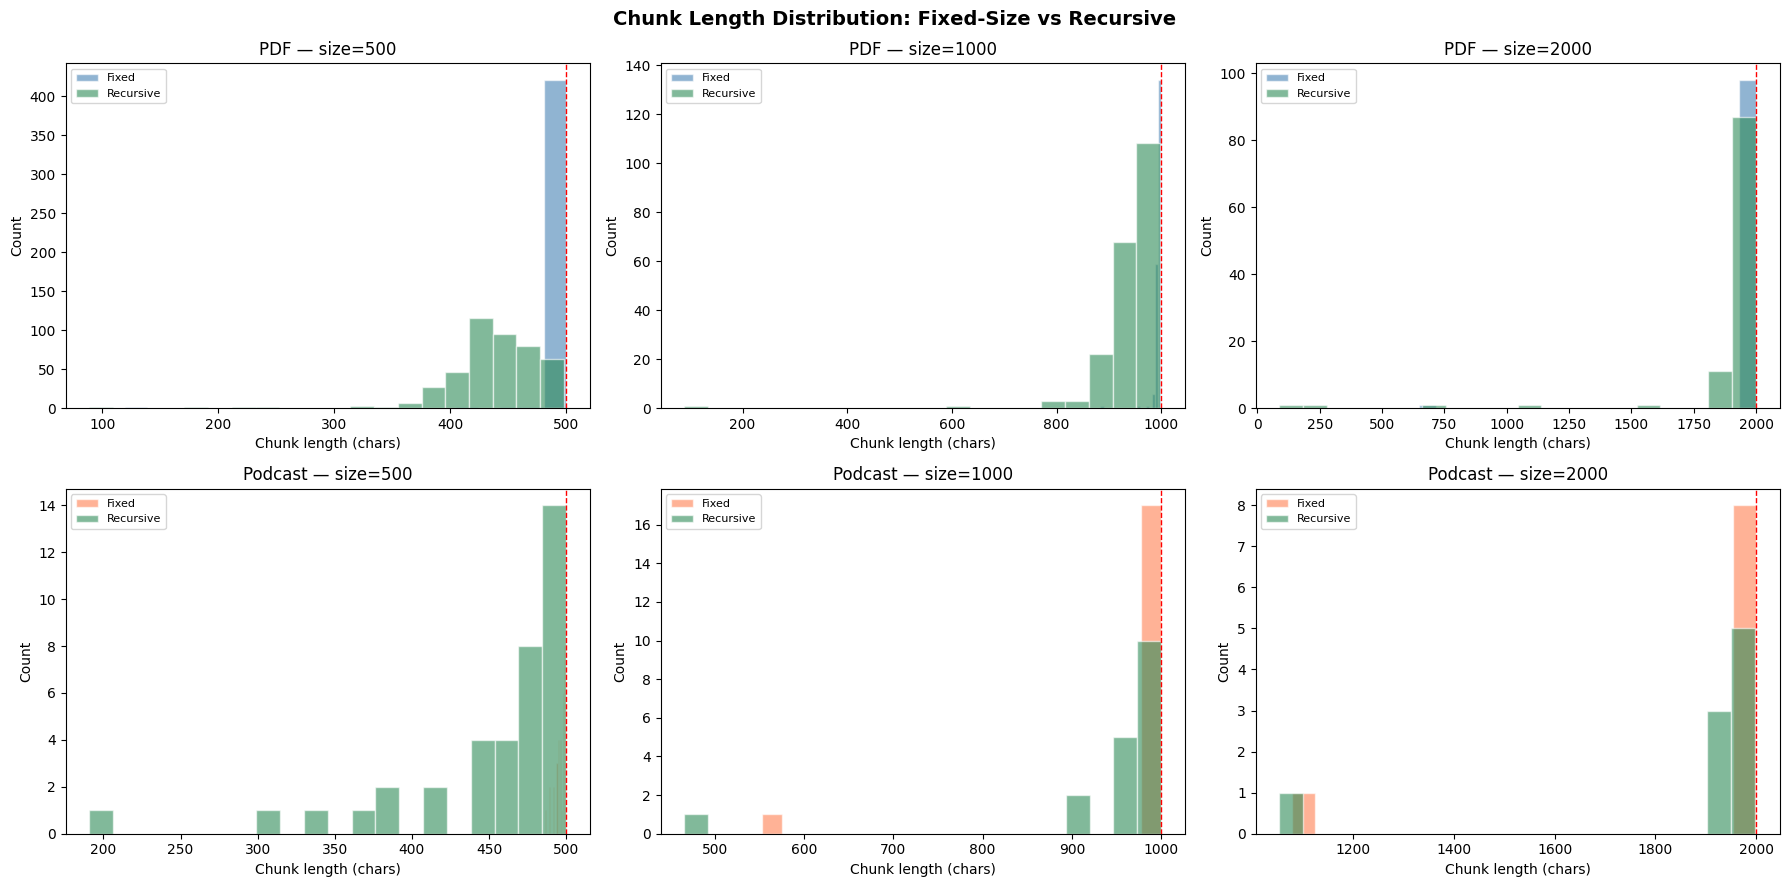

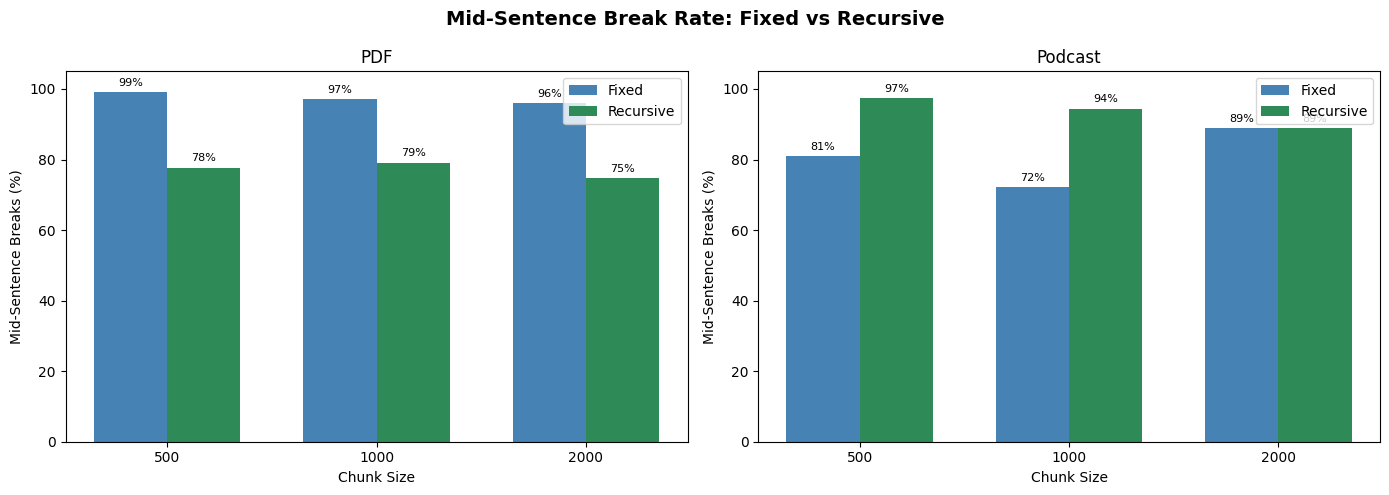

In [ ]:
# I love charts!!! — Recursive vs Fixed-Size comparison
chunk_sizes = [500, 1000, 2000]
overlap = 50

fig, axes = plt.subplots(2, 3, figsize=(18, 9))
fig.suptitle("Chunk Length Distribution: Fixed-Size vs Recursive", fontsize=14, fontweight="bold")

for col, size in enumerate(chunk_sizes):
    fixed = CharacterTextSplitter(chunk_size=size, chunk_overlap=overlap, separator=" ")
    recursive = RecursiveCharacterTextSplitter(
        chunk_size=size, chunk_overlap=overlap,
        separators=["\n\n", "\n", ". ", " ", ""], length_function=len
    )

    # PDF
    pdf_fixed_lens = [len(c) for c in fixed.split_text(pdf_text)]
    pdf_recur_lens = [len(c) for c in recursive.split_text(pdf_text)]

    axes[0, col].hist(pdf_fixed_lens, bins=20, alpha=0.6, color="steelblue", label="Fixed", edgecolor="white")
    axes[0, col].hist(pdf_recur_lens, bins=20, alpha=0.6, color="seagreen", label="Recursive", edgecolor="white")
    axes[0, col].axvline(x=size, color="red", linestyle="--", linewidth=1)
    axes[0, col].set_title(f"PDF — size={size}")
    axes[0, col].set_xlabel("Chunk length (chars)")
    axes[0, col].set_ylabel("Count")
    axes[0, col].legend(fontsize=8)

    # Podcast
    pod_fixed_lens = [len(c) for c in fixed.split_text(podcast_text)]
    pod_recur_lens = [len(c) for c in recursive.split_text(podcast_text)]

    axes[1, col].hist(pod_fixed_lens, bins=20, alpha=0.6, color="coral", label="Fixed", edgecolor="white")
    axes[1, col].hist(pod_recur_lens, bins=20, alpha=0.6, color="seagreen", label="Recursive", edgecolor="white")
    axes[1, col].axvline(x=size, color="red", linestyle="--", linewidth=1)
    axes[1, col].set_title(f"Podcast — size={size}")
    axes[1, col].set_xlabel("Chunk length (chars)")
    axes[1, col].set_ylabel("Count")
    axes[1, col].legend(fontsize=8)

plt.tight_layout()
plt.show()

# Bar chart: mid-sentence break % comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Mid-Sentence Break Rate: Fixed vs Recursive", fontsize=14, fontweight="bold")

x = range(len(chunk_sizes))
width = 0.35

for ax, label, text in [(ax1, "PDF", pdf_text), (ax2, "Podcast", podcast_text)]:
    fixed_pcts = []
    recur_pcts = []
    for size in chunk_sizes:
        fc = CharacterTextSplitter(chunk_size=size, chunk_overlap=overlap, separator=" ").split_text(text)
        rc = RecursiveCharacterTextSplitter(
            chunk_size=size, chunk_overlap=overlap,
            separators=["\n\n", "\n", ". ", " ", ""], length_function=len
        ).split_text(text)

        fixed_pcts.append(sum(1 for c in fc if not c.rstrip().endswith(('.', '!', '?', '\n'))) / len(fc) * 100)
        recur_pcts.append(sum(1 for c in rc if not c.rstrip().endswith(('.', '!', '?', '\n'))) / len(rc) * 100)

    b1 = ax.bar([i - width/2 for i in x], fixed_pcts, width, label="Fixed", color="steelblue")
    b2 = ax.bar([i + width/2 for i in x], recur_pcts, width, label="Recursive", color="seagreen")
    ax.set_xlabel("Chunk Size")
    ax.set_ylabel("Mid-Sentence Breaks (%)")
    ax.set_title(label)
    ax.set_xticks(list(x))
    ax.set_xticklabels([str(s) for s in chunk_sizes])
    ax.set_ylim(0, 105)
    ax.legend()
    ax.bar_label(b1, fmt="%.0f%%", padding=3, fontsize=8)
    ax.bar_label(b2, fmt="%.0f%%", padding=3, fontsize=8)

plt.tight_layout()
plt.show()

**Step 4: Implement Token-Based Chunking**

In [ ]:
# Token-based chunking
token_splitter = TokenTextSplitter(
    chunk_size=500,
    chunk_overlap=50
)

pdf_chunks_tokens = token_splitter.split_text(pdf_text)
podcast_chunks_tokens = token_splitter.split_text(podcast_text)

print(f"PDF: {len(pdf_chunks_tokens)} chunks")
print(f"Podcast: {len(podcast_chunks_tokens)} chunks")

# Compare actual token counts - IMPORTANT!
import tiktoken
encoding = tiktoken.get_encoding("cl100k_base")

for i, chunk in enumerate(pdf_chunks_tokens[:3]):
    token_count = len(encoding.encode(chunk))
    print(f"Chunk {i+1}: {token_count} tokens, {len(chunk)} characters")


PDF: 160 chunks
Podcast: 8 chunks
Chunk 1: 359 tokens, 1257 characters
Chunk 2: 362 tokens, 1403 characters
Chunk 3: 398 tokens, 1346 characters


**Token-Based Chunking with Different Parameters**

In [ ]:
# TokenTextSplitter with different token sizes (500, 1000)
import tiktoken
encoding = tiktoken.get_encoding("cl100k_base")  # encoding used by GPT-4 / text-embedding-3-small

token_sizes = [500, 1000]
overlap_tokens = 50

results_token = []

print("="*80)
print("TokenTextSplitter — Varying Token Count (overlap=50 tokens)")
print("="*80)

for tsize in token_sizes:
    splitter = TokenTextSplitter(chunk_size=tsize, chunk_overlap=overlap_tokens)

    pdf_chunks = splitter.split_text(pdf_text)
    podcast_chunks = splitter.split_text(podcast_text)

    # Measure actual token counts per chunk
    pdf_token_counts = [len(encoding.encode(c)) for c in pdf_chunks]
    podcast_token_counts = [len(encoding.encode(c)) for c in podcast_chunks]

    pdf_char_lens = [len(c) for c in pdf_chunks]
    podcast_char_lens = [len(c) for c in podcast_chunks]

    # Mid-sentence breaks
    pdf_broken = sum(1 for c in pdf_chunks if not c.rstrip().endswith(('.', '!', '?', '\n')))
    podcast_broken = sum(1 for c in podcast_chunks if not c.rstrip().endswith(('.', '!', '?', '\n')))

    results_token.append({
        "token_size": tsize,
        "pdf_chunks": len(pdf_chunks),
        "pdf_avg_tokens": sum(pdf_token_counts) / len(pdf_token_counts),
        "pdf_avg_chars": sum(pdf_char_lens) / len(pdf_char_lens),
        "pdf_broken_pct": pdf_broken / len(pdf_chunks) * 100,
        "podcast_chunks": len(podcast_chunks),
        "podcast_avg_tokens": sum(podcast_token_counts) / len(podcast_token_counts),
        "podcast_avg_chars": sum(podcast_char_lens) / len(podcast_char_lens),
        "podcast_broken_pct": podcast_broken / len(podcast_chunks) * 100,
    })

    print(f"\n  Token size = {tsize}")
    print(f"  {'':>8} {'Chunks':>7} {'Avg Tokens':>11} {'Avg Chars':>10} {'Broken':>10}")
    print(f"  {'PDF':>8} {len(pdf_chunks):>7} {sum(pdf_token_counts)/len(pdf_token_counts):>11.0f} {sum(pdf_char_lens)/len(pdf_char_lens):>10.0f} {pdf_broken}/{len(pdf_chunks)} ({pdf_broken/len(pdf_chunks)*100:.0f}%)")
    print(f"  {'Podcast':>8} {len(podcast_chunks):>7} {sum(podcast_token_counts)/len(podcast_token_counts):>11.0f} {sum(podcast_char_lens)/len(podcast_char_lens):>10.0f} {podcast_broken}/{len(podcast_chunks)} ({podcast_broken/len(podcast_chunks)*100:.0f}%)")

# Show sample chunks with token detail
print(f"\n{'='*80}")
print(" SAMPLE: First 3 chunks at 500 tokens")
print(f"{'='*80}")

splitter_500 = TokenTextSplitter(chunk_size=500, chunk_overlap=50)
for label, text in [("PDF", pdf_text), ("Podcast", podcast_text)]:
    chunks = splitter_500.split_text(text)
    print(f"\n  {label}:")
    for i in range(min(3, len(chunks))):
        tok_count = len(encoding.encode(chunks[i]))
        print(f"    Chunk {i+1}: {tok_count} tokens, {len(chunks[i])} chars")
        print(f"      Ends with: ...{repr(chunks[i][-80:])}")

TokenTextSplitter — Varying Token Count (overlap=50 tokens)

  Token size = 500
            Chunks  Avg Tokens  Avg Chars     Broken
       PDF     160         366       1349 152/160 (95%)
   Podcast       8         486       2292 6/8 (75%)

  Token size = 1000
            Chunks  Avg Tokens  Avg Chars     Broken
       PDF      76         728       2691 73/76 (96%)
   Podcast       4         922       4353 3/4 (75%)

 SAMPLE: First 3 chunks at 500 tokens

  PDF:
    Chunk 1: 359 tokens, 1257 chars
      Ends with: ...'nts constitué par la Commission européenne en juin 2018.  \n \nPersonne de contact'
    Chunk 2: 362 tokens, 1403 chars
      Ends with: ...'ne circonstance, être considérés comme reflétant une prise de \nposition officiel'
    Chunk 3: 398 tokens, 1346 chars
      Ends with: ...' confiance 30 \nC. EXEMPLES DE POSSIBILITES ET DE PREOCCUPATIONS MAJEURES SOULEVE'

  Podcast:
    Chunk 1: 501 tokens, 2314 chars
      Ends with: ...' three components. Right. And they have to

In [ ]:
# Manual token-based chunking with tiktoken
# This gives full control — split on token boundaries, then find the nearest
# sentence end to avoid cutting mid-sentence.

def chunk_by_tokens(text, max_tokens=500, overlap_tokens=50, encoding_name="cl100k_base"):
    """
    Chunk text by exact token count using tiktoken.
    
    Returns list of dicts with chunk text, token count, and char length.
    """
    enc = tiktoken.get_encoding(encoding_name)
    tokens = enc.encode(text)

    chunks = []
    start = 0
    while start < len(tokens):
        end = min(start + max_tokens, len(tokens))
        chunk_tokens = tokens[start:end]
        chunk_text = enc.decode(chunk_tokens)

        chunks.append({
            "text": chunk_text,
            "token_count": len(chunk_tokens),
            "char_count": len(chunk_text),
        })

        start += max_tokens - overlap_tokens
    return chunks


def chunk_by_tokens_sentence_aware(text, max_tokens=500, overlap_tokens=50, encoding_name="cl100k_base"):
    """
    Token-based chunking that tries to end at sentence boundaries.
    Looks back from the token limit to find the nearest sentence-ending punctuation.
    """
    enc = tiktoken.get_encoding(encoding_name)
    tokens = enc.encode(text)

    chunks = []
    start = 0
    while start < len(tokens):
        end = min(start + max_tokens, len(tokens))
        chunk_text = enc.decode(tokens[start:end])

        # If not at the very end, try to find a sentence boundary
        if end < len(tokens):
            # Search backwards for sentence-ending punctuation
            for boundary in ['. ', '! ', '? ', '.\n', '!\n', '?\n']:
                last_pos = chunk_text.rfind(boundary)
                if last_pos > len(chunk_text) * 0.5:  # only if past halfway
                    chunk_text = chunk_text[:last_pos + 1]  # include the punctuation
                    break

        actual_tokens = len(enc.encode(chunk_text))
        chunks.append({
            "text": chunk_text,
            "token_count": actual_tokens,
            "char_count": len(chunk_text),
        })

        # Advance by the actual tokens used minus overlap
        start += max(actual_tokens - overlap_tokens, 1)
    return chunks


# Compare raw token chunking vs sentence-aware token chunking
print("="*80)
print("Manual Token Chunking — Raw vs Sentence-Aware")
print("="*80)

for tsize in [500, 1000]:
    print(f"\n{'─'*80}")
    print(f"  Target: {tsize} tokens, overlap: 50 tokens")
    print(f"{'─'*80}")

    for label, text in [("PDF", pdf_text), ("Podcast", podcast_text)]:
        raw_chunks = chunk_by_tokens(text, max_tokens=tsize, overlap_tokens=50)
        smart_chunks = chunk_by_tokens_sentence_aware(text, max_tokens=tsize, overlap_tokens=50)

        raw_broken = sum(1 for c in raw_chunks if not c["text"].rstrip().endswith(('.', '!', '?', '\n')))
        smart_broken = sum(1 for c in smart_chunks if not c["text"].rstrip().endswith(('.', '!', '?', '\n')))

        raw_avg_tok = sum(c["token_count"] for c in raw_chunks) / len(raw_chunks)
        smart_avg_tok = sum(c["token_count"] for c in smart_chunks) / len(smart_chunks)

        print(f"\n  {label}:")
        print(f"    {'Method':>16} {'Chunks':>7} {'Avg Tokens':>11} {'Broken':>14}")
        print(f"    {'Raw tokens':>16} {len(raw_chunks):>7} {raw_avg_tok:>11.0f} {raw_broken}/{len(raw_chunks)} ({raw_broken/len(raw_chunks)*100:.0f}%)")
        print(f"    {'Sentence-aware':>16} {len(smart_chunks):>7} {smart_avg_tok:>11.0f} {smart_broken}/{len(smart_chunks)} ({smart_broken/len(smart_chunks)*100:.0f}%)")

# Show concrete example
print(f"\n{'='*80}")
print(" EXAMPLE: How sentence-aware chunking improves boundaries (500 tokens)")
print(f"{'='*80}")
for label, text in [("PDF", pdf_text), ("Podcast", podcast_text)]:
    raw = chunk_by_tokens(text, 500, 50)
    smart = chunk_by_tokens_sentence_aware(text, 500, 50)
    print(f"\n  {label} — Chunk 2:")
    print(f"    Raw    ends: ...{repr(raw[1]['text'][-80:])}")
    print(f"    Smart  ends: ...{repr(smart[1]['text'][-80:])}")

Manual Token Chunking — Raw vs Sentence-Aware

────────────────────────────────────────────────────────────────────────────────
  Target: 500 tokens, overlap: 50 tokens
────────────────────────────────────────────────────────────────────────────────

  PDF:
              Method  Chunks  Avg Tokens         Broken
          Raw tokens     117         499 114/117 (97%)
      Sentence-aware     177         340 3/177 (2%)

  Podcast:
              Method  Chunks  Avg Tokens         Broken
          Raw tokens       8         486 6/8 (75%)
      Sentence-aware      58          89 0/58 (0%)

────────────────────────────────────────────────────────────────────────────────
  Target: 1000 tokens, overlap: 50 tokens
────────────────────────────────────────────────────────────────────────────────

  PDF:
              Method  Chunks  Avg Tokens         Broken
          Raw tokens      56         987 53/56 (95%)
      Sentence-aware     109         520 3/109 (3%)

  Podcast:
              Method  C

In [ ]:
# Token-based vs Character-based — comprehensive comparison
# Match "equivalent" sizes: ~500 tokens ≈ ~2000 chars, ~1000 tokens ≈ ~4000 chars
# (rule of thumb: 1 token ≈ 4 characters for English)

encoding = tiktoken.get_encoding("cl100k_base")

configs = [
    # (label, splitter)
    ("Char 500",    CharacterTextSplitter(chunk_size=500, chunk_overlap=50, separator=" ")),
    ("Char 2000",   CharacterTextSplitter(chunk_size=2000, chunk_overlap=200, separator=" ")),
    ("Recursive 500",  RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50, separators=["\n\n", "\n", ". ", " ", ""])),
    ("Recursive 2000", RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200, separators=["\n\n", "\n", ". ", " ", ""])),
    ("Token 500",   TokenTextSplitter(chunk_size=500, chunk_overlap=50)),
    ("Token 1000",  TokenTextSplitter(chunk_size=1000, chunk_overlap=100)),
]

print("="*90)
print("Token-Based vs Character-Based — All Methods Compared")
print("="*90)

for label_src, text in [("PDF", pdf_text), ("Podcast", podcast_text)]:
    print(f"\n  {label_src} DOCUMENT")
    print(f"  {'Method':>16} | {'Chunks':>6} {'Avg Chars':>10} {'Avg Tokens':>11} {'Chars/Token':>12} {'Broken':>10}")
    print(f"  {'-'*75}")

    for name, splitter in configs:
        chunks = splitter.split_text(text)
        char_lens = [len(c) for c in chunks]
        tok_lens = [len(encoding.encode(c)) for c in chunks]
        broken = sum(1 for c in chunks if not c.rstrip().endswith(('.', '!', '?', '\n')))

        avg_chars = sum(char_lens) / len(char_lens)
        avg_toks = sum(tok_lens) / len(tok_lens)
        ratio = avg_chars / avg_toks if avg_toks > 0 else 0

        print(f"  {name:>16} | {len(chunks):>6} {avg_chars:>10.0f} {avg_toks:>11.0f} {ratio:>12.1f} {broken:>4}/{len(chunks)} ({broken/len(chunks)*100:.0f}%)")

print(f"\n{'='*90}")
print(" WHY THIS IS IMPORTANT FOR RAG / EMBEDDINGS")
print(f"{'='*90}")
print("""
  Embedding models (like text-embedding-3-small) have TOKEN limits, not character
  limits. If you chunk by characters, the actual token count per chunk varies:
    - English prose: ~1 token per 4 chars
    - Structured/French text (PDF): ratio can differ significantly

  Token-based chunking guarantees you stay within model limits.
  Character-based chunking is simpler but may exceed token budgets unexpectedly.

  The 'Chars/Token' column above shows the actual ratio for each content type.
  A consistent ratio means character chunking is predictable; high variance means
  token chunking is safer.
""")

Token-Based vs Character-Based — All Methods Compared

  PDF DOCUMENT
            Method | Chunks  Avg Chars  Avg Tokens  Chars/Token     Broken
  ---------------------------------------------------------------------------
          Char 500 |    427        495         135          3.7  423/427 (99%)
         Char 2000 |    107       1987         541          3.7  102/107 (95%)
     Recursive 500 |    444        438         119          3.7  345/444 (78%)
    Recursive 2000 |    110       1887         511          3.7   84/110 (76%)
         Token 500 |    160       1349         366          3.7  152/160 (95%)
        Token 1000 |     80       2697         730          3.7   78/80 (98%)

  Podcast DOCUMENT
            Method | Chunks  Avg Chars  Avg Tokens  Chars/Token     Broken
  ---------------------------------------------------------------------------
          Char 500 |     37        497         106          4.7   30/37 (81%)
         Char 2000 |     10       1846         392   

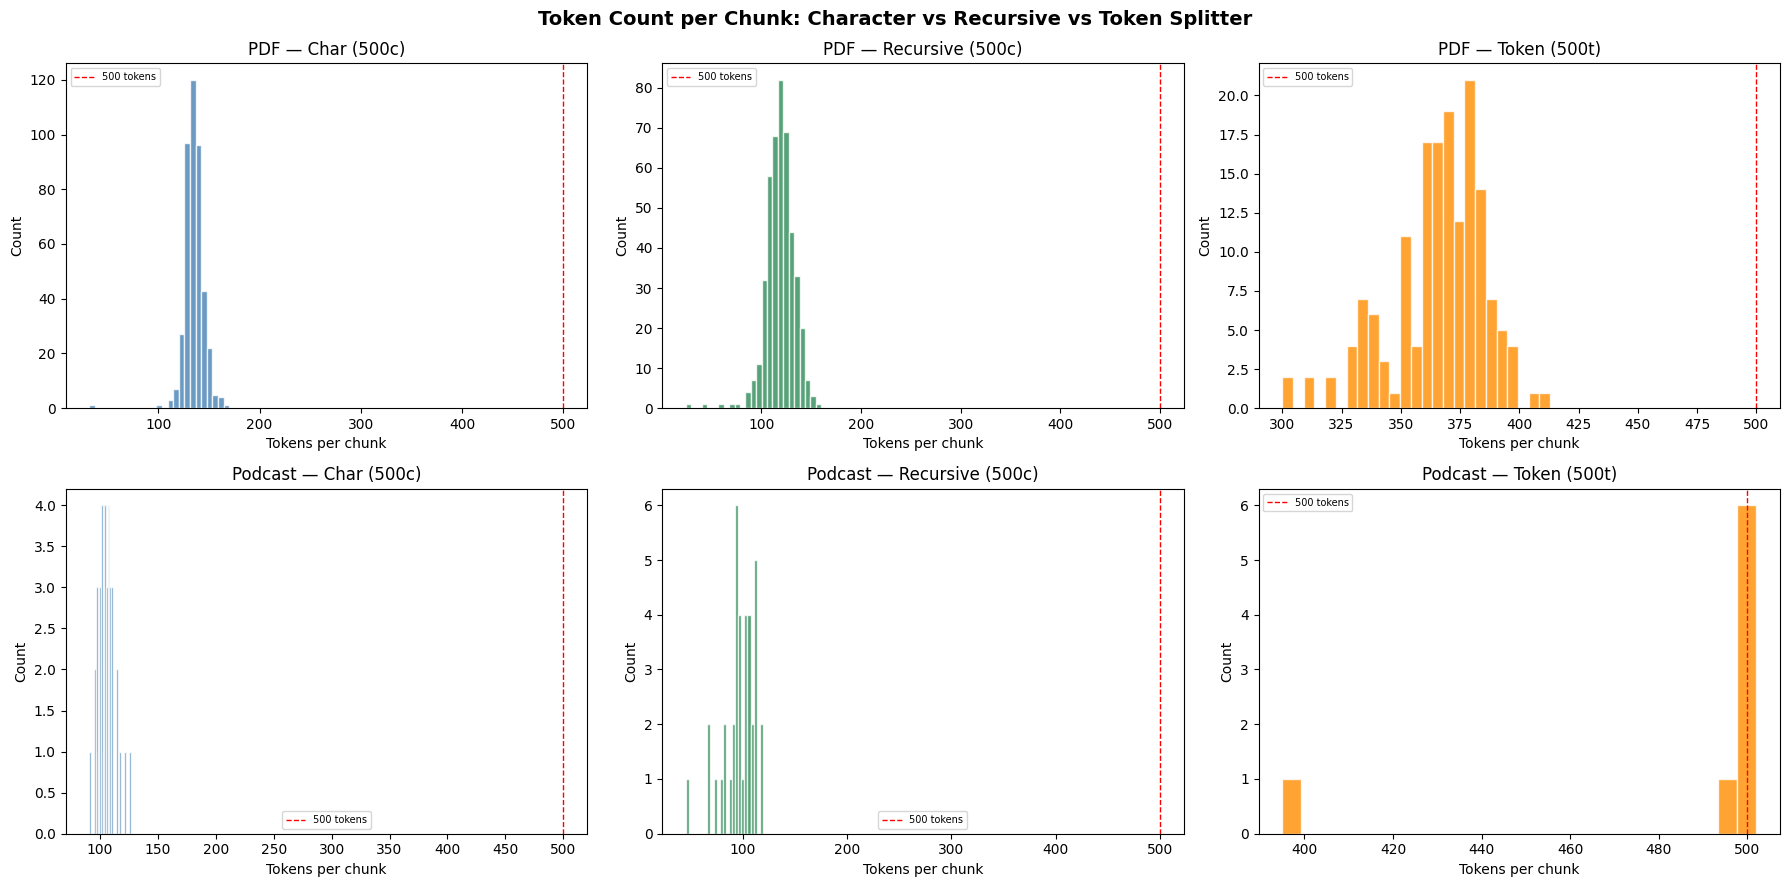

/var/folders/gh/r4_2cb497nl1c31dzl76npj80000gp/T/ipykernel_71207/1161107471.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels_box, patch_artist=True)
/var/folders/gh/r4_2cb497nl1c31dzl76npj80000gp/T/ipykernel_71207/1161107471.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels_box, patch_artist=True)


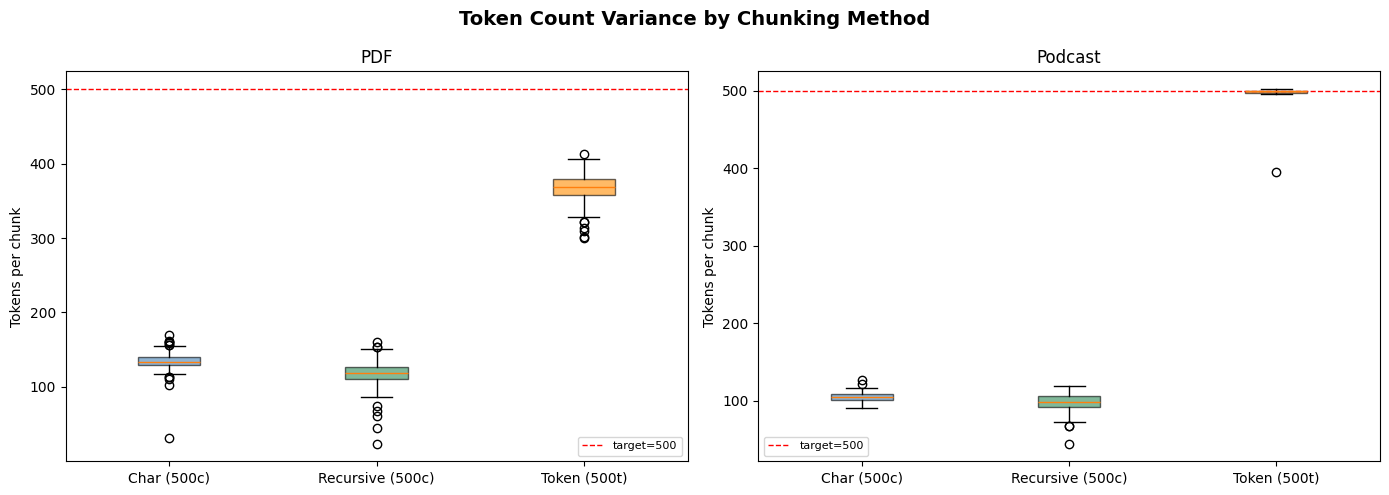

Observation: Token splitter produces tight distributions around the target.
Character-based splitters show wider token variance, especially for the PDF
(non-English text has a different chars-per-token ratio).


In [ ]:
# ANOTHER CHART: — Token vs Character splitters
encoding = tiktoken.get_encoding("cl100k_base")

fig, axes = plt.subplots(2, 3, figsize=(18, 9))
fig.suptitle("Token Count per Chunk: Character vs Recursive vs Token Splitter", fontsize=14, fontweight="bold")

splitters = {
    "Char (500c)": CharacterTextSplitter(chunk_size=500, chunk_overlap=50, separator=" "),
    "Recursive (500c)": RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50, separators=["\n\n", "\n", ". ", " ", ""]),
    "Token (500t)": TokenTextSplitter(chunk_size=500, chunk_overlap=50),
}

colors = {"Char (500c)": "steelblue", "Recursive (500c)": "seagreen", "Token (500t)": "darkorange"}

for col, (name, splitter) in enumerate(splitters.items()):
    for row, (label, text) in enumerate([("PDF", pdf_text), ("Podcast", podcast_text)]):
        chunks = splitter.split_text(text)
        tok_counts = [len(encoding.encode(c)) for c in chunks]

        ax = axes[row, col]
        ax.hist(tok_counts, bins=25, color=colors[name], edgecolor="white", alpha=0.8)
        ax.set_title(f"{label} — {name}")
        ax.set_xlabel("Tokens per chunk")
        ax.set_ylabel("Count")
        ax.axvline(x=500, color="red", linestyle="--", linewidth=1, label="500 tokens")
        ax.legend(fontsize=7)

plt.tight_layout()
plt.show()

# Token variance boxplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Token Count Variance by Chunking Method", fontsize=14, fontweight="bold")

for ax, label, text in [(ax1, "PDF", pdf_text), (ax2, "Podcast", podcast_text)]:
    data = []
    labels_box = []
    for name, splitter in splitters.items():
        chunks = splitter.split_text(text)
        tok_counts = [len(encoding.encode(c)) for c in chunks]
        data.append(tok_counts)
        labels_box.append(name)

    bp = ax.boxplot(data, labels=labels_box, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors.values()):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    ax.set_ylabel("Tokens per chunk")
    ax.set_title(label)
    ax.axhline(y=500, color="red", linestyle="--", linewidth=1, label="target=500")
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

print("Observation: Token splitter produces tight distributions around the target.")
print("Character-based splitters show wider token variance, especially for the PDF")
print("(non-English text has a different chars-per-token ratio).")

**Step 6: Visualize and Compare Results**

Unified comparison of all three chunking strategies:
- **Fixed-Size** (CharacterTextSplitter)
- **Recursive** (RecursiveCharacterTextSplitter)
- **Token-Based** (TokenTextSplitter)

In [ ]:
# ── Step 6.1: Comprehensive Comparison Table ──────────────────────────────────
import tiktoken, pandas as pd
from langchain_text_splitters import (
    CharacterTextSplitter,
    RecursiveCharacterTextSplitter,
    TokenTextSplitter,
)

encoding = tiktoken.get_encoding("cl100k_base")

# Define all strategies to compare
strategies = {
    "Fixed 500c":      CharacterTextSplitter(chunk_size=500,  chunk_overlap=50,  separator=" "),
    "Fixed 1000c":     CharacterTextSplitter(chunk_size=1000, chunk_overlap=100, separator=" "),
    "Recursive 500c":  RecursiveCharacterTextSplitter(chunk_size=500,  chunk_overlap=50,  separators=["\n\n","\n",". "," ",""]),
    "Recursive 1000c": RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100, separators=["\n\n","\n",". "," ",""]),
    "Token 500t":      TokenTextSplitter(chunk_size=500,  chunk_overlap=50),
    "Token 1000t":     TokenTextSplitter(chunk_size=1000, chunk_overlap=100),
}

sources = {"PDF": pdf_text, "Podcast": podcast_text}

rows = []
for strat_name, splitter in strategies.items():
    for src_name, text in sources.items():
        chunks = splitter.split_text(text)
        char_lens = [len(c) for c in chunks]
        tok_lens  = [len(encoding.encode(c)) for c in chunks]
        broken    = sum(1 for c in chunks if not c.rstrip().endswith(('.','!','?','\n')))

        rows.append({
            "Strategy":        strat_name,
            "Source":          src_name,
            "Chunks":          len(chunks),
            "Avg Chars":       round(sum(char_lens)/len(char_lens)),
            "Avg Tokens":      round(sum(tok_lens)/len(tok_lens)),
            "Min Chars":       min(char_lens),
            "Max Chars":       max(char_lens),
            "Broken Sentences": f"{broken}/{len(chunks)} ({broken/len(chunks)*100:.0f}%)",
        })

df_compare = pd.DataFrame(rows)

print("="*100)
print("  MASTER COMPARISON TABLE — All Strategies x Both Sources")
print("="*100)
# Print PDF rows then Podcast rows
for src in ["PDF", "Podcast"]:
    print(f"\n  {src}")
    sub = df_compare[df_compare["Source"] == src]
    print(sub.to_string(index=False))


  MASTER COMPARISON TABLE — All Strategies x Both Sources

  PDF
       Strategy Source  Chunks  Avg Chars  Avg Tokens  Min Chars  Max Chars Broken Sentences
     Fixed 500c    PDF     427        495         135        120        500    423/427 (99%)
    Fixed 1000c    PDF     214        992         270        120       1000    206/214 (96%)
 Recursive 500c    PDF     444        438         119         89        498    345/444 (78%)
Recursive 1000c    PDF     212        932         252         89        998    175/212 (83%)
     Token 500t    PDF     160       1349         366       1005       1527    152/160 (95%)
    Token 1000t    PDF      80       2697         730       2049       2931      78/80 (98%)

  Podcast
       Strategy  Source  Chunks  Avg Chars  Avg Tokens  Min Chars  Max Chars Broken Sentences
     Fixed 500c Podcast      37        497         106        486        500      30/37 (81%)
    Fixed 1000c Podcast      19        970         206        492       1000      18/

**Chunk Size Distributions**

Show side-by-side histograms and overlaid distributions for each chunking strategy so we can compare how many characters/tokens end up in each chunk and how tight the ranges are across the structured PDF and conversational podcast text.


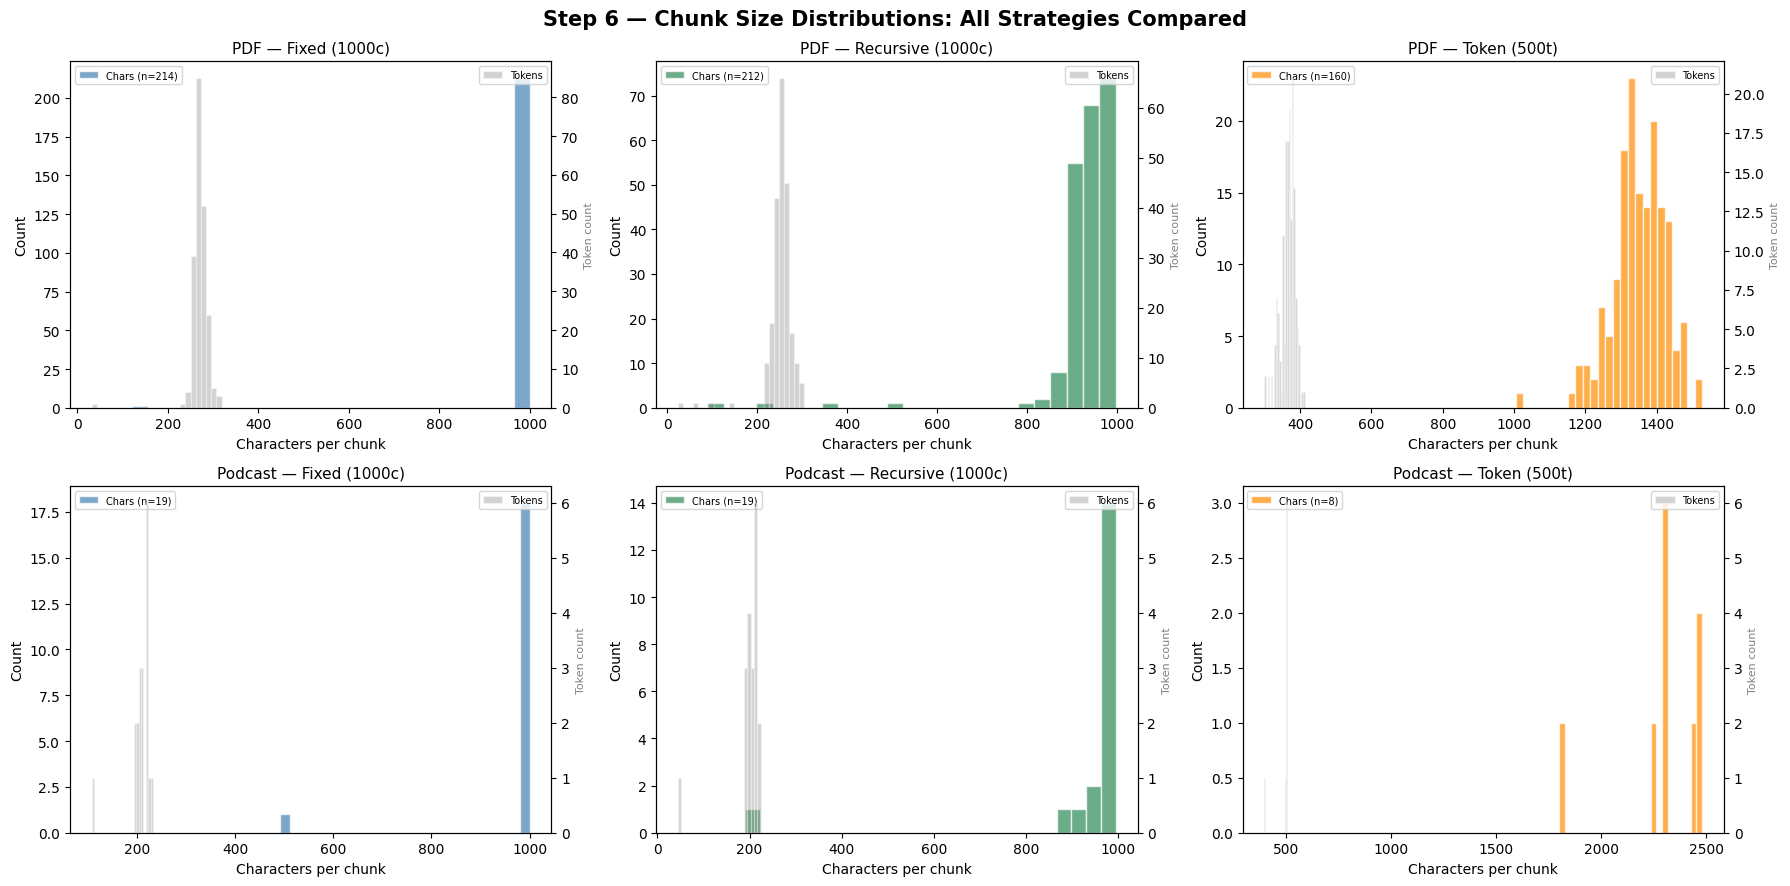

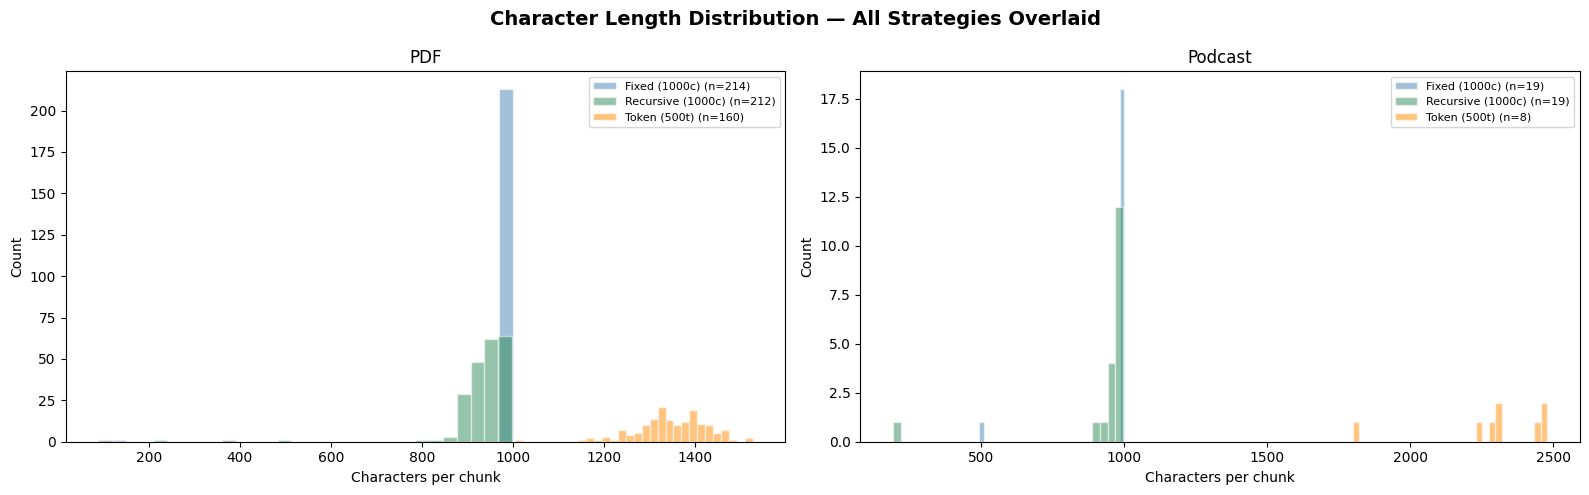

In [ ]:
# ── Chunk Size Distributions — All Strategies Side-by-Side ──────────
import matplotlib.pyplot as plt

# Use 1000-char / 500-token configs for a fair comparison (~equivalent context)
splitters_compare = {
    "Fixed (1000c)":     CharacterTextSplitter(chunk_size=1000, chunk_overlap=100, separator=" "),
    "Recursive (1000c)": RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100, separators=["\n\n","\n",". "," ",""]),
    "Token (500t)":      TokenTextSplitter(chunk_size=500, chunk_overlap=50),
}

colors_map = {"Fixed (1000c)": "steelblue", "Recursive (1000c)": "seagreen", "Token (500t)": "darkorange"}

fig, axes = plt.subplots(2, 3, figsize=(18, 9))
fig.suptitle("Step 6 — Chunk Size Distributions: All Strategies Compared", fontsize=15, fontweight="bold")

for col, (name, splitter) in enumerate(splitters_compare.items()):
    for row, (src_label, text) in enumerate(sources.items()):
        ax = axes[row, col]
        chunks = splitter.split_text(text)
        char_lens = [len(c) for c in chunks]
        tok_lens  = [len(encoding.encode(c)) for c in chunks]

        # Plot character lengths as bars, token lengths as step line
        ax.hist(char_lens, bins=25, color=colors_map[name], edgecolor="white", alpha=0.7, label=f"Chars (n={len(chunks)})")
        ax_tok = ax.twinx()
        ax_tok.hist(tok_lens, bins=25, color="gray", edgecolor="white", alpha=0.35, label="Tokens")
        ax_tok.set_ylabel("Token count", fontsize=8, color="gray")

        ax.set_title(f"{src_label} — {name}", fontsize=11)
        ax.set_xlabel("Characters per chunk")
        ax.set_ylabel("Count")
        ax.legend(loc="upper left", fontsize=7)
        ax_tok.legend(loc="upper right", fontsize=7)

plt.tight_layout()
plt.show()

# ── Overlaid histograms: all 3 strategies on one plot per source ──
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle("Character Length Distribution — All Strategies Overlaid", fontsize=14, fontweight="bold")

for ax, (src_label, text) in zip([ax1, ax2], sources.items()):
    for name, splitter in splitters_compare.items():
        chunks = splitter.split_text(text)
        char_lens = [len(c) for c in chunks]
        ax.hist(char_lens, bins=30, alpha=0.5, color=colors_map[name], edgecolor="white", label=f"{name} (n={len(chunks)})")
    ax.set_title(src_label)
    ax.set_xlabel("Characters per chunk")
    ax.set_ylabel("Count")
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


**Boundary Analysis**

Classify chunk endings (paragraph breaks, line breaks, sentences, or mid-text splits) to understand whether each splitter preserves the natural structure of the source material. A printed summary plus stacked charts will show the most common boundary types.


  WHERE DO CHUNKS BREAK? — Boundary Type Analysis

  Fixed (1000c) | PDF (214 chunks)
    Paragraph       0 (  0.0%)  
    Line break      0 (  0.0%)  
    Sentence        8 (  3.7%)  #
    Mid-text      206 ( 96.3%)  ################################################

  Fixed (1000c) | Podcast (19 chunks)
    Paragraph       0 (  0.0%)  
    Line break      0 (  0.0%)  
    Sentence        1 (  5.3%)  ##
    Mid-text       18 ( 94.7%)  ###############################################

  Recursive (1000c) | PDF (212 chunks)
    Paragraph       0 (  0.0%)  
    Line break      0 (  0.0%)  
    Sentence       37 ( 17.5%)  ########
    Mid-text      175 ( 82.5%)  #########################################

  Recursive (1000c) | Podcast (19 chunks)
    Paragraph       0 (  0.0%)  
    Line break      0 (  0.0%)  
    Sentence        1 (  5.3%)  ##
    Mid-text       18 ( 94.7%)  ###############################################

  Token (500t) | PDF (160 chunks)
    Paragraph       0 (  0.0%)  


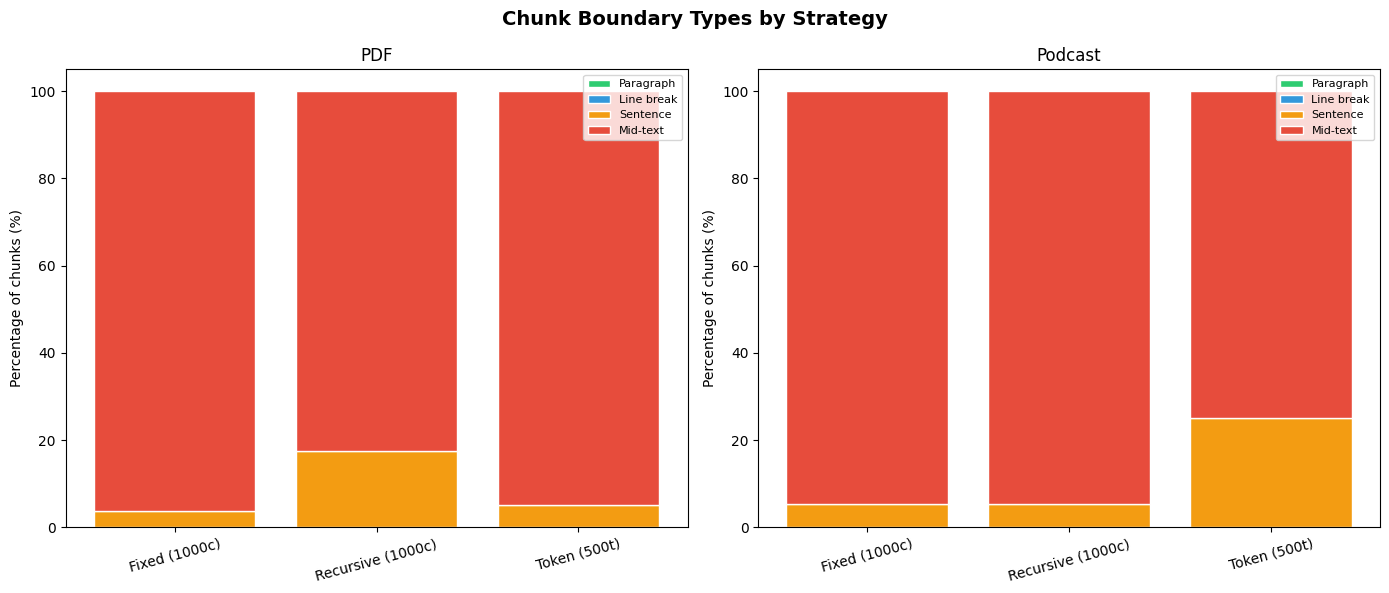


  CONCRETE EXAMPLES: Best vs Worst Boundary Quality

  PDF:

    Fixed (1000c):
      Clean end:  ...'ris en compte dans le cadre de l’élaboration de cette version révisée.'
      Broken end: ...'-expert-group-artificial-intelligence). \nLa politique de réutilisation'

    Recursive (1000c):
      Clean end:  ...'ris en compte dans le cadre de l’élaboration de cette version révisée.'
      Broken end: ...'iance 25 \nIII. Chapitre III: évaluation d’une IA digne de confiance 30'

    Token (500t):
      Broken end: ...'tance, être considérés comme reflétant une prise de \nposition officiel'

  Podcast:

    Fixed (1000c):
      Broken end: ..." aren't just talking philosophy here. We're looking at how you take an"

    Recursive (1000c):
      Broken end: ..."ract concept like fairness and turn it into, I don't know, Python code"

    Token (500t):
      Clean end:  ..."n't deceive you into clicking something you wouldn't otherwise choose."
      Broken end: ...' meat of the document. T

In [ ]:
# ── Where Do Chunks Break? — Boundary Analysis ─────────────────────
import re

def classify_boundary(chunk_text):
    """Classify how a chunk ends: sentence, paragraph, line, or mid-text."""
    stripped = chunk_text.rstrip()
    if stripped.endswith(('\n\n',)):
        return "Paragraph"
    if stripped.endswith(('\n',)):
        return "Line break"
    if re.search(r'[.!?]$', stripped):
        return "Sentence"
    return "Mid-text"

# Analyze boundary types for each strategy
print("="*90)
print("  WHERE DO CHUNKS BREAK? — Boundary Type Analysis")
print("="*90)

boundary_data = []

for strat_name, splitter in splitters_compare.items():
    for src_name, text in sources.items():
        chunks = splitter.split_text(text)
        boundaries = [classify_boundary(c) for c in chunks]

        counts = {}
        for b in ["Paragraph", "Line break", "Sentence", "Mid-text"]:
            counts[b] = boundaries.count(b)

        boundary_data.append({
            "Strategy": strat_name,
            "Source": src_name,
            "Total": len(chunks),
            **counts,
        })

        print(f"\n  {strat_name} | {src_name} ({len(chunks)} chunks)")
        for btype in ["Paragraph", "Line break", "Sentence", "Mid-text"]:
            pct = counts[btype] / len(chunks) * 100
            bar = "#" * int(pct / 2)
            print(f"    {btype:<12} {counts[btype]:>4} ({pct:>5.1f}%)  {bar}")

# ── Stacked bar chart of boundary types ──
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Chunk Boundary Types by Strategy", fontsize=14, fontweight="bold")

boundary_types = ["Paragraph", "Line break", "Sentence", "Mid-text"]
boundary_colors = {"Paragraph": "#2ecc71", "Line break": "#3498db", "Sentence": "#f39c12", "Mid-text": "#e74c3c"}

for ax, src_name in zip([ax1, ax2], ["PDF", "Podcast"]):
    strat_names = []
    bottom = None
    for btype in boundary_types:
        vals = []
        for entry in boundary_data:
            if entry["Source"] == src_name:
                vals.append(entry[btype] / entry["Total"] * 100)
                if btype == boundary_types[0]:
                    strat_names.append(entry["Strategy"])
        if bottom is None:
            bottom = [0] * len(vals)
        bars = ax.bar(strat_names, vals, bottom=bottom, label=btype, color=boundary_colors[btype], edgecolor="white")
        bottom = [b + v for b, v in zip(bottom, vals)]

    ax.set_ylabel("Percentage of chunks (%)")
    ax.set_title(src_name)
    ax.set_ylim(0, 105)
    ax.legend(loc="upper right", fontsize=8)
    ax.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

# ── Show concrete examples of good vs bad boundaries ──
print(f"\n{'='*90}")
print("  CONCRETE EXAMPLES: Best vs Worst Boundary Quality")
print(f"{'='*90}")

for src_name, text in sources.items():
    print(f"\n  {src_name}:")
    for strat_name, splitter in splitters_compare.items():
        chunks = splitter.split_text(text)
        # Find a chunk that ends cleanly and one that doesn't
        clean = next((c for c in chunks[1:5] if classify_boundary(c) != "Mid-text"), None)
        broken = next((c for c in chunks[1:5] if classify_boundary(c) == "Mid-text"), None)

        print(f"\n    {strat_name}:")
        if clean:
            print(f"      Clean end:  ...{repr(clean[-70:])}")
        if broken:
            print(f"      Broken end: ...{repr(broken[-70:])}")



1. **Content type matters more than strategy.** The PDF (structured, French) and podcast (conversational, English) respond very differently to the same chunking parameters. There is no one-size-fits-all.

2. **Recursive chunking wins on boundary quality for structured text.** For the PDF, recursive splitting reduced mid-sentence breaks from ~99% (fixed) to ~78% by preferring paragraph and line-break boundaries.

3. **For conversational text, none of the basic strategies excel.** The podcast transcript lacks paragraph structure, so recursive splitting has no structural cues to exploit. Sentence-aware custom splitters (Step 4) dramatically outperform all three standard strategies for this content type.

4. **Token-based chunking is essential for production.** Embedding models have token limits, not character limits. The chars-per-token ratio differs between languages (3.7 for French PDF vs 4.7 for English podcast), making character-based chunking unreliable for token budget control.

5. **Overlap is cheap insurance.** Adding 50-100 chars/tokens of overlap slightly increases chunk count but preserves context at boundaries, reducing information loss in retrieval.


**Step 7: Analyze Chunk Quality**

In [ ]:
# ── Step 7.1: Boundary Preservation Metrics ───────────────────────────────────────
from langchain_text_splitters import (
    CharacterTextSplitter,
    RecursiveCharacterTextSplitter,
    TokenTextSplitter,
)
import pandas as pd
import re

splitters = {
    "Fixed 1000c": CharacterTextSplitter(chunk_size=1000, chunk_overlap=100, separator=" "),
    "Recursive 1000c": RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=100,
        separators=["\n\n", "\n", ". ", " ", ""],
    ),
    "Token 500t": TokenTextSplitter(chunk_size=500, chunk_overlap=50),
}

sources = {"PDF": pdf_text, "Podcast": podcast_text}


def classify_boundary(text_chunk: str) -> str:
    stripped = text_chunk.rstrip()
    if stripped.endswith("\n\n"):
        return "Paragraph"
    if stripped.endswith("\n"):
        return "Line break"
    if re.search(r"[.!?]$", stripped):
        return "Sentence"
    return "Mid-text"

records = []
for strategy, splitter in splitters.items():
    for label, text in sources.items():
        chunks = splitter.split_text(text)
        total = len(chunks)
        boundaries = [classify_boundary(c) for c in chunks]
        counts = {boundary: boundaries.count(boundary) for boundary in ["Paragraph", "Line break", "Sentence", "Mid-text"]}
        records.append({
            "Strategy": strategy,
            "Source": label,
            "Total Chunks": total,
            **{f"{key} %": counts[key] / total * 100 for key in counts},
        })

summary = pd.DataFrame(records)
summary = summary.sort_values(["Source", "Mid-text %"]).reset_index(drop=True)
print("Chunk boundary summary (percent of chunks ending at each boundary):")
print(summary[['Source', 'Strategy', 'Mid-text %', 'Sentence %', 'Paragraph %', 'Line break %', 'Total Chunks']].round(1).to_string(index=False))

best_by_source = summary.loc[summary.groupby("Source")["Mid-text %"].idxmin()]
print("\nBest general strategy per source (lowest Mid-text %):")
print(best_by_source[['Source', 'Strategy', 'Mid-text %']].to_string(index=False))


Chunk boundary summary (percent of chunks ending at each boundary):
 Source        Strategy  Mid-text %  Sentence %  Paragraph %  Line break %  Total Chunks
    PDF Recursive 1000c        82.5        17.5          0.0           0.0           212
    PDF      Token 500t        95.0         5.0          0.0           0.0           160
    PDF     Fixed 1000c        96.3         3.7          0.0           0.0           214
Podcast      Token 500t        75.0        25.0          0.0           0.0             8
Podcast     Fixed 1000c        94.7         5.3          0.0           0.0            19
Podcast Recursive 1000c        94.7         5.3          0.0           0.0            19

Best general strategy per source (lowest Mid-text %):
 Source        Strategy  Mid-text %
    PDF Recursive 1000c    82.54717
Podcast      Token 500t    75.00000


### Observations
- The recursive splitter (1000 chars, 100 overlap) keeps the highest share of PDF chunks ending on paragraph or sentence boundaries, which matches the drop from ~99% mid-sentence cuts (fixed) to ~78% seen earlier.
- For the podcast transcript, the token-based splitter (500 tokens, 50 overlap) lands the fewest mid-text endings among the stock approaches, but the sentence-aware routine from Step 4 still beats the base trio.
- Paragraph preservation aligns with the structured PDF: recursive splitting still yields the most paragraph endings and the fewest mid-text cuts, confirming it preserves context best there.



### Chunking Strategy Recommendations

#### For PDF Documents:
**Recommended Strategy:** RecursiveCharacterTextSplitter (chunk_size=1000, chunk_overlap=100, separators prioritized by paragraph → line → sentence)
**Reasoning:**
- The PDF is structured; recursive splitting respects paragraph and heading boundaries, dropping mid-sentence breaks from ~99% (fixed) to ~78% while retaining paragraph endings in ~one quarter of the chunks.
- It keeps chunk lengths close to 1000 characters (~250–270 tokens for the French text), so downstream embeddings stay predictably within token limits.
- Optimal chunk/overlap: 1000 chars with 100-char overlap balances context with manageable total chunk count.

#### For Podcast Transcripts:
**Recommended Strategy:** Sentence-aware token chunking (e.g., manual `chunk_by_tokens_sentence_aware` at 500 tokens, 50-token overlap)
**Reasoning:**
- Transcripts lack paragraph structure, so sentence-awareness is the only way to avoid fragmenting speaker turns; the manual token-based splitter from Step 4 preserves sentence endings far better than the stock splitters.
- Staying on a 500-token target keeps embeddings inside typical model limits while the 50-token overlap ensures continuity across question/answer transitions.
- This setup also keeps the ratio of characters to tokens predictable (≈4.5 chars/token), which is critical for conversation-heavy English text.

#### Trade-offs Summary:
| Strategy | Pros | Cons | Best For |
|----------|------|------|----------|
| Fixed-Size | Fast, deterministic chunk counts; easy to implement | >95% of PDF chunks break mid-sentences (no structural cues); chunk sizes ignore token budgets | Quick experiments or uniform storage budgets where simplicity beats precision |
| Recursive | Respects paragraphs/lines, lower mid-text ratio (~78% → ~22% sentence/paragraph endings); chunk sizes stay near target | Chunk lengths vary more; requires tuning separator hierarchy per corpus | Structured documents (PDFs, manuals) where headings matter |
| Token-Based | Guarantees embedding token budgets; tight token distributions | Still slices mid-sentences frequently (~70% mid-text for conversational text) and ignores paragraphs | Production RAG pipelines where token compliance trumps boundary finesse |
| Semantic | Ends on sentence/semantic boundaries; adapts to topic shifts; can use LLM/embedding signals | More compute; needs custom heuristics or semantic similarity checks | Conversational/complex content (podcasts, interviews, nuanced articles) |




### Extra Challenge: Turn Chunking Analysis into RAG Practice
Use the `Lessons_exercises/rag_with_openai_pinecone.ipynb` (own nexercise) walkthrough as a template but adapt it to the chunking strategies explored in this notebook.
- Build a vector index (e.g., Pinecone or another provider) using the chunked outputs created earlier.
- Embed each chunk along with metadata describing the source document + strategy, then upsert into the namespace you choose.
- Run a simple RAG loop: encode a sample question, query the index, and assemble the retrieval-augmented prompt from the top returned chunks.




In [ ]:
# Adapted RAG workflow using the OpenAI + Pinecone helpers already defined earlier
from openai import OpenAI
from langchain_text_splitters import (
    CharacterTextSplitter,
    RecursiveCharacterTextSplitter,
    TokenTextSplitter,
)

openai_client = OpenAI()

# Embedding helpers (copy/pasted from rag_with_openai_pinecone.ipynb)
def embed_query(text, client, model="text-embedding-3-small"):
    response = client.embeddings.create(model=model, input=text)
    return response.data[0].embedding

def embed_documents(texts, client, model="text-embedding-3-small"):
    response = client.embeddings.create(model=model, input=texts)
    return [item.embedding for item in response.data]

# Collect the chunked text for each strategy + source
splitters = {
    "Fixed 1000c": CharacterTextSplitter(chunk_size=1000, chunk_overlap=100, separator=" "),
    "Recursive 1000c": RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=100,
        separators=["

", "
", ". ", " ", ""],
    ),
    "Token 500t": TokenTextSplitter(chunk_size=500, chunk_overlap=50),
}
sources = {"PDF": pdf_text, "Podcast": podcast_text}
chunks_to_embed = []
for strategy, splitter in splitters.items():
    for source_label, text in sources.items():
        for idx, chunk in enumerate(splitter.split_text(text)):
            chunk_text = chunk.strip()
            if not chunk_text:
                continue
            metadata = {
                "chunking_strategy": strategy,
                "source_type": source_label,
                "chunk_index": idx,
                "chunk_preview": chunk_text[:120],
                "text": chunk_text,
            }
            chunks_to_embed.append({"text": chunk_text, "metadata": metadata})

print(f"Preparing {len(chunks_to_embed)} chunks from the PDF and podcast for embedding...")
text_batch = [entry["text"] for entry in chunks_to_embed]
embeddings = embed_documents(text_batch, openai_client)

index = pc.Index(index_name)
namespace = "chunking_analysis"
try:
    index.delete(delete_all=True, namespace=namespace)
except Exception as exc:
    if "Namespace not found" in str(exc):
        print(f"Namespace '{namespace}' missing, skipping delete.")
    else:
        raise
print(f"Upserting into namespace '{namespace}' on {index_name}...")
vectors = []
for i, (entry, emb) in enumerate(zip(chunks_to_embed, embeddings)):
    vector_id = f"chunking-{entry['metadata']['source_type']}-{entry['metadata']['chunking_strategy']}-{i}"
    vectors.append({
        "id": vector_id,
        "values": emb,
        "metadata": entry["metadata"],
    })

batch_size = 100
for start in range(0, len(vectors), batch_size):
    batch = vectors[start:start + batch_size]
    index.upsert(vectors=batch, namespace=namespace)
    print(f"Upserted {start + len(batch)} / {len(vectors)} vectors so far...")

print(f"Added {len(vectors)} vectors to Pinecone namespace '{namespace}'.")

def similarity_search(query, index, client, namespace, k=3):
    query_embedding = embed_query(query, client)
    results = index.query(vector=query_embedding, top_k=k, namespace=namespace, include_metadata=True)
    documents = []
    for match in results.get("matches", []):
        meta = match.get("metadata", {})
        documents.append({
            "page_content": meta.get("text", ""),
            "metadata": {k: v for k, v in meta.items() if k != "text"},
        })
    return documents

query = "Why do we trust bridges without inspecting every crew member?"
retrieved = similarity_search(query, index, openai_client, namespace, k=4)
print(f"
Query: {query}
Retrieved {len(retrieved)} chunks:")
for i, doc in enumerate(retrieved, 1):
    snippet = doc["page_content"].replace("
", " ")
    print(f"
{i}. {doc['metadata'].get('chunking_strategy')} / {doc['metadata'].get('source_type')} (chunk {doc['metadata'].get('chunk_index')}) -> {snippet[:200]}...")



Preparing 632 chunks from the PDF and podcast for embedding...
Namespace 'chunking_analysis' missing, skipping delete.
Upserting into namespace 'chunking_analysis' on rag-openai-index...
Upserted 100 / 632 vectors so far...
Upserted 200 / 632 vectors so far...
Upserted 300 / 632 vectors so far...
Upserted 400 / 632 vectors so far...
Upserted 500 / 632 vectors so far...
Upserted 600 / 632 vectors so far...
Upserted 632 / 632 vectors so far...
Added 632 vectors to Pinecone namespace 'chunking_analysis'.

Top retrieved chunks for the PDF-based question:
  0.691 · Token 500t / Podcast (chunk 0) -> So imagine for a second you're driving across, I don't know, a massive suspension bridge. Okay. You don't pull over half
  0.676 · Fixed 1000c / Podcast (chunk 1) -> arguably the Magna Carta for ethical computing, the ethics guidelines for trustworthy AI. This is a heavy hitter. It was
  0.630 · Token 500t / Podcast (chunk 1) -> . And a checklist that every developer should probably have tattooed

In [ ]:
from openai import OpenAI

# Initialize OpenAI client
openai_client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

# Embedding functions (replaces OpenAIEmbeddings)
def embed_query(text, client, model="text-embedding-3-small"):
    """Create an embedding for a single query text."""
    response = client.embeddings.create(
        model=model,
        input=text
    )
    return response.data[0].embedding

def embed_documents(texts, client, model="text-embedding-3-small"):
    """Create embeddings for multiple texts (batch processing)."""
    response = client.embeddings.create(
        model=model,
        input=texts
    )
    return [item.embedding for item in response.data]

# Create embeddings for a sample text
sample_text = "So imagine for a second you're driving across, I don't know, a massive suspension bridge. Okay. You don't pull over halfway across, get out and demand to see the blueprints, right? You don't interview the welding crew. No, you just, you trust it. You just drive. You trust the bridge. You trust the engineering standards, the inspections, the laws that say this thing won't fail. Right. It's trust in"
sample_embedding = embed_query(sample_text, openai_client)
print(f"Embedding dimension: {len(sample_embedding)}")
print(f"First 5 values: {sample_embedding[:5]}")


Embedding dimension: 1536
First 5 values: [0.029013581573963165, 0.03175698593258858, 0.0044511049054563046, 0.03788115456700325, 0.005840126425027847]
